# Proyecto (pre-entrega)

Alumno: Javier López Malone

Profesora: Daniela Putrino

Tutor: Virginia Marich

## Información del dataset

> Moro,S., Rita,P., and Cortez,P.. (2012). Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

Los datos están relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá un depósito a plazo (variable y).

### Datos del cliente bancario:

**Edad** (numérica): edad del cliente.

**Tipo de Trabajo** (categórica): 'gestión', 'obrero', 'emprendedor', 'empleado doméstico', 'administrativo', 'jubilado', 'autónomo', 'servicios', 'estudiante', ' técnico', 'desempleado', 'desconocido'.

**Estado Civil** (categórica):  'divorciado', 'casado', 'soltero', 'desconocido'. Nota: 'divorciado' contempla divorciado o viudo.

**Educación** (categórica): 'primario', 'secundario', 'terciario', 'desconocido'.

**Incumplimiento** (categórica): ¿tiene crédito en incumplimiento? 'si', 'no'.

**Hipoteca** (categórica): ¿tiene préstamo de vivienda? 'si', 'no'

**Préstamo** (categórica): ¿tiene préstamo personal? 'si', 'no'

### Datos de la campaña:

**Contacto** (categórica): tipo de comunicación del contacto 'celular', 'teléfono'.

**Mes** (categórica): mes del año del último contacto 'ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'

**Día** (categórica): día de la semana 'lun', 'mar', 'mie', 'jue', 'vie'.

**Duración** (numérica): duración del último contacto, en segundos. Nota importante: este atributo afecta en gran medida el objetivo de salida (por ejemplo, si duración=0 entonces y='no'). Sin embargo, no se conoce la duración antes de realizar una llamada. Además, después del final de la llamada, obviamente se conoce y.
Por lo tanto, esta entrada sólo debe incluirse con fines de referencia y debe descartarse si la intención es tener un modelo predictivo realista.
Otros atributos:

**Campaña** (numérica): número de contactos realizados durante la campaña al cliente (incluye el último contacto).

**Días transcurridos** (numérica): número de días transcurridos después de que el cliente fue contactado por última vez desde una campaña anterior. Nota: 999 significa que el cliente no fue contactado previamente.

**Contacto Anterior** (numérica): número de contactos realizados antes de esta campaña a este cliente.

**Resultado** (categórica): resultado de la campaña de marketing anterior 'éxito', 'fracaso', 'desconocido'.

### Datos de contexto socio-económico

**Emp.var.rate** (numérica): tasa de variación del empleo, indicador trimestral

**Cons.price.idx** (numérica): índice de precios al consumidor, indicador mensual.

**Cons.conf.idx** (numérica): índice de confianza del consumidor, indicador mensual.

**Euribor3m** (numérica): tipo de cambio euribor a 3 meses, indicador diario.

**Nr.empleados** (numérica): número de empleados, indicador trimestral.

## Importación de librerías y dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/Cursos/DataScienceII_Challenge/datasets/bank-additional-full.csv',sep=';')
pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Funciones auxiliares

Funciones que se utilizarán en el documento.

In [3]:

# HELPER FUNCTIONS

from enum import Enum
from tabulate import tabulate

class OutliersTreatment(Enum):
    DoNothing = 0
    Delete = 1
    Truncate = 2
    ApplyMean = 3
    ApplyMedian = 4


def describe_data(dataFrame: pd.DataFrame) -> pd.DataFrame:
    desc = df.describe().T

    mode_values = df.select_dtypes(include=['float64', 'int64']).mode().iloc[0] 

    median_values = df.select_dtypes(include=['float64', 'int64']).median()

    desc['mode'] = mode_values
    desc['median'] = median_values
    
    return desc


def get_outliers_IQR(dataFrame: pd.DataFrame, columns:str|list=None, treatment:OutliersTreatment=OutliersTreatment.DoNothing):
    """
    Calcula los valores atípicos de las columnas del dataframe según el rango intercuartílico (IQR)
    
    Returns:
        dataFrame: DataFrame con los valores atípicos tratados
        outliers: DataFrame con los valores atípicos
    """
    not_processed_columns = None
    
    if columns is None:
        not_processed_columns = dataFrame.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
        columns = dataFrame.select_dtypes(include=['float64', 'int64']).columns.tolist()
    else:
        not_processed_columns = dataFrame[columns].select_dtypes(exclude=['float64', 'int64']).columns.tolist()
        columns = dataFrame[columns].select_dtypes(include=['float64', 'int64']).columns.tolist()
        
    if not not_processed_columns is None and len(not_processed_columns)>0:
        print(f"Columnas no procesadas:\n{not_processed_columns}\n")
    
    if columns:
        Q1 = dataFrame[columns].quantile(0.25)
        Q3 = dataFrame[columns].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (dataFrame[columns] < lower_bound) | (dataFrame[columns] > upper_bound)

        if treatment == OutliersTreatment.Delete:
            dataFrame = dataFrame[~outliers.any(axis=1)]
        elif treatment == OutliersTreatment.Truncate:
            for column in columns:
                dataFrame[column] = np.where(
                                        dataFrame[column] < lower_bound[column], lower_bound[column],
                                        np.where(dataFrame[column] > upper_bound[column], upper_bound[column], 
                                        dataFrame[column])
                                    )
        elif treatment == OutliersTreatment.ApplyMean:
            for column in columns:
                mean_value = dataFrame[column].mean()
                dataFrame[column] = np.where(outliers[column], mean_value, dataFrame[column])
        elif treatment == OutliersTreatment.ApplyMedian:
           for column in columns:
                median_value = dataFrame[column].median()
                dataFrame[column] = np.where(outliers[column], median_value, dataFrame[column])
                        
        return (dataFrame, outliers)
    else:
        return None
    
    
def show_outliers_info(dataFrame: pd.DataFrame, columns:str|list=None, summary:bool=True):
    """
    Obtiene la inforamción de los valores atípicos de las columnas del dataframe.
    
    Returns:
        outliers: DataFrame con los valores atípicos
    """
    if columns is None:
        columns = dataFrame.select_dtypes(include=['float64', 'int64']).columns.tolist()
    else:
        columns = dataFrame[columns].select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    
    _, outliers = get_outliers_IQR(dataFrame, columns)
    
    if summary:
        outliers_count = outliers.sum()

        table_data = []

        for column, outlier_count in outliers_count.items():
            if column in columns:
                outliers_column_percentage = outlier_count / dataFrame[column].count() * 100
                table_data.append([column, outlier_count, f"{outliers_column_percentage:.2f}%"])

        total_outliers_count = outliers_count.sum()
        total_data_points = dataFrame.select_dtypes(include=['float64', 'int64']).count().sum()
        total_percentage = total_outliers_count / total_data_points * 100

        total_row = ['Total', total_outliers_count, f"{total_percentage:.2f}%"]

        headers = ['Columna', 'Outliers', '% del total']

        table_data = sorted(table_data, key=lambda x: x[1], reverse=True)
        table_data.append(total_row) 

        print(tabulate(table_data, headers=headers, tablefmt='pretty'))
    else:
        for column in columns:
            print(f"{column}: {outliers[column].sum()} outliers")
            print(dataFrame[column][outliers[column] == True].head())
            
    print()
    
    return outliers

### Traducción de valores y columnas

Establezco todos los valores y columnas en español por preferencia personal.

In [4]:
job_translations = {
    'management':'gestión',
    'technician':'técnico',
    'entrepreneur':'emprendedor',
    'blue-collar':'obrero',
    'retired':'jubilado',
    'admin.':'administrativo',
    'services':'servicios',
    'self-employed':'autónomo',
    'unemployed':'desempleado',
    'housemaid':'servicio doméstico',
    'student':'estudiante',
    'unknown':'desconocido'
}
df['job'] = df['job'].replace(job_translations)

marital_status_translations = {
    'married':'casado/a',
    'single':'soltero/a',
    'divorced':'divorciado/a',
    'unknown':'desconocido'
}
df['marital'] = df['marital'].replace(marital_status_translations)

education_translations = {
    'basic.4y':'básica 4 años',
    'basic.6y':'básica 6 años',
    'basic.9y':'básica 9 años',
    'high.school':'bachillerato',
    'professional.course':'curso profesional',
    'university.degree':'grado universitario',
    'illiterate':'analfabeto',
    'unknown':'desconocido'
}
df['education'] = df['education'].replace(education_translations)

contact_translations = {
    'cellular':'celular',
    'telephone':'teléfono',
    'unknown':'desconocido'
}
df['contact'] = df['contact'].replace(contact_translations)

month_translations = {
    'jan':'ene',
    'feb':'feb',
    'mar':'mar',
    'apr':'abr',
    'may':'may',
    'jun':'jun',
    'jul':'jul',
    'aug':'ago',
    'sep':'sep',
    'oct':'oct',
    'nov':'nov',
    'dec':'dic'
}
df['month'] = df['month'].replace(month_translations)

day_of_week_translations = {
    'mon':'lun',
    'tue':'mar',
    'wen':'mie',
    'thu':'jue',
    'fri':'vie'
}
df['day_of_week'] = df['day_of_week'].replace(day_of_week_translations)

poutcome_translations = {
    'success':'éxito',
    'failure':'fracaso',
    'nonexistent':'desconocido'
}
df['poutcome'] = df['poutcome'].replace(poutcome_translations)

yes_no_translations = {
    'yes':'si',
    'unknown':'desconocido'
}
df['default'] = df['default'].replace(yes_no_translations)
df['housing'] = df['housing'].replace(yes_no_translations)
df['loan'] = df['loan'].replace(yes_no_translations)
df['y'] = df['y'].replace(yes_no_translations)

class Col:
    AGE = "Edad"
    JOB = "Tipo de trabajo"
    MARITAL = "Estado civil"
    EDUCATION = "Educación"
    DEFAULT = "Incumplimientos"
    BALANCE = "Balance"
    HOUSING = "Hipoteca"
    LOAN = "Préstamos"
    CONTACT = "Contacto"
    FIRST_CONTACT = "Primer contacto"
    MONTH = "Mes"
    DAY_OF_WEEK = "Día semana"
    DURATION = "Duración"
    CAMPAIGN = "Campaña"
    PDAYS = "Días transcurridos"
    PREVIOUS = "Contacto Anterior"
    POUTCOME = "Resultado"
    EMP_VAR_RATE = "Tasa var. empleo"
    CONS_PRICE_IDX = "Idx precio consum."
    CONS_CONF_IDX = "Idx confianza consum."
    EURIBOR3M = "Euribor 3M"
    NR_EMPLOYED = "Nr. empleados"
    Y = "Y"
    
columns_translations = {
    'age': Col.AGE,
    'job': Col.JOB,
    'marital': Col.MARITAL,
    'education': Col.EDUCATION,
    'default': Col.DEFAULT,
    'balance': Col.BALANCE,
    'housing': Col.HOUSING,
    'loan': Col.LOAN,
    'contact': Col.CONTACT,
    'month': Col.MONTH,
    'day_of_week': Col.DAY_OF_WEEK,
    'duration': Col.DURATION,
    'campaign': Col.CAMPAIGN,
    'pdays': Col.PDAYS,
    'previous': Col.PREVIOUS,
    'poutcome': Col.POUTCOME,
    'emp.var.rate': Col.EMP_VAR_RATE,
    'cons.price.idx': Col.CONS_PRICE_IDX,
    'cons.conf.idx': Col.CONS_CONF_IDX,
    'euribor3m': Col.EURIBOR3M,
    'nr.employed': Col.NR_EMPLOYED,
    'y': Col.Y
}
df.rename(columns=columns_translations, inplace=True)

### Descripción del dataset

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Edad                   41176 non-null  float64
 1   Tipo de trabajo        41176 non-null  object 
 2   Estado civil           41176 non-null  object 
 3   Educación              41176 non-null  object 
 4   Incumplimientos        41176 non-null  object 
 5   Hipoteca               41176 non-null  object 
 6   Préstamos              41176 non-null  object 
 7   Contacto               41176 non-null  object 
 8   Primer contacto        41176 non-null  int64  
 9   Mes                    41176 non-null  object 
 10  Día semana             41176 non-null  object 
 11  Duración               41176 non-null  float64
 12  Campaña                41176 non-null  float64
 13  Días transcurridos     41176 non-null  int64  
 14  Contacto Anterior      41176 non-null  int64  
 15  Resulta

In [5]:
describe_data(df)

count    mean    std     min     25%     50%     75%  \
Edad                  41188.00   40.02  10.42   17.00   32.00   38.00   47.00   
Duración              41188.00  258.29 259.28    0.00  102.00  180.00  319.00   
Campaña               41188.00    2.57   2.77    1.00    1.00    2.00    3.00   
Días transcurridos    41188.00  962.48 186.91    0.00  999.00  999.00  999.00   
Contacto Anterior     41188.00    0.17   0.49    0.00    0.00    0.00    0.00   
Tasa var. empleo      41188.00    0.08   1.57   -3.40   -1.80    1.10    1.40   
Idx precio consum.    41188.00   93.58   0.58   92.20   93.08   93.75   93.99   
Idx confianza consum. 41188.00  -40.50   4.63  -50.80  -42.70  -41.80  -36.40   
Euribor 3M            41188.00    3.62   1.73    0.63    1.34    4.86    4.96   
Nr. empleados         41188.00 5167.04  72.25 4963.60 5099.10 5191.00 5228.10   

                          max    mode  median  
Edad                    98.00   31.00   38.00  
Duración              4918.00   85.00  180.00  
Campaña                 56.00    1.00    2.00  
Días transcurridos     999.00  999.00  999.00  
Contacto Anterior        7.00    0.00    0.00  
Tasa var. empleo         1.40    1.40    1.10  
Idx precio consum.      94.77   93.99   93.75  
Idx confianza consum.  -26.90  -36.40  -41.80  
Euribor 3M               5.04    4.86    4.86  
Nr. empleados         5228.10 5228.10 5191.00

In [6]:
df.head(10)

Edad     Tipo de trabajo Estado civil          Educación Incumplimientos  \
0    56  servicio doméstico     casado/a      básica 4 años              no   
1    57           servicios     casado/a       bachillerato     desconocido   
2    37           servicios     casado/a       bachillerato              no   
3    40      administrativo     casado/a      básica 6 años              no   
4    56           servicios     casado/a       bachillerato              no   
5    45           servicios     casado/a      básica 9 años     desconocido   
6    59      administrativo     casado/a  curso profesional              no   
7    41              obrero     casado/a        desconocido     desconocido   
8    24             técnico    soltero/a  curso profesional              no   
9    25           servicios    soltero/a       bachillerato              no   

  Hipoteca Préstamos  Contacto  Mes Día semana  Duración  Campaña  \
0       no        no  teléfono  may        lun       261        1   
1       no        no  teléfono  may        lun       149        1   
2       si        no  teléfono  may        lun       226        1   
3       no        no  teléfono  may        lun       151        1   
4       no        si  teléfono  may        lun       307        1   
5       no        no  teléfono  may        lun       198        1   
6       no        no  teléfono  may        lun       139        1   
7       no        no  teléfono  may        lun       217        1   
8       si        no  teléfono  may        lun       380        1   
9       si        no  teléfono  may        lun        50        1   

   Días transcurridos  Contacto Anterior    Resultado  Tasa var. empleo  \
0                 999                  0  desconocido              1.10   
1                 999                  0  desconocido              1.10   
2                 999                  0  desconocido              1.10   
3                 999                  0  desconocido              1.10   
4                 999                  0  desconocido              1.10   
5                 999                  0  desconocido              1.10   
6                 999                  0  desconocido              1.10   
7                 999                  0  desconocido              1.10   
8                 999                  0  desconocido              1.10   
9                 999                  0  desconocido              1.10   

   Idx precio consum.  Idx confianza consum.  Euribor 3M  Nr. empleados   Y  
0               93.99                 -36.40        4.86        5191.00  no  
1               93.99                 -36.40        4.86        5191.00  no  
2               93.99                 -36.40        4.86        5191.00  no  
3               93.99                 -36.40        4.86        5191.00  no  
4               93.99                 -36.40        4.86        5191.00  no  
5               93.99                 -36.40        4.86        5191.00  no  
6               93.99                 -36.40        4.86        5191.00  no  
7               93.99                 -36.40        4.86        5191.00  no  
8               93.99                 -36.40        4.86        5191.00  no  
9               93.99                 -36.40        4.86        5191.00  no

In [7]:
for column in df.select_dtypes(include=['object']).columns:
    print (f"Hay {df[column].nunique()} valores únicos en la columna {column}: {', '.join(sorted(df[column].unique()))}")

Hay 12 valores únicos en la columna Tipo de trabajo: administrativo, autónomo, desconocido, desempleado, emprendedor, estudiante, gestión, jubilado, obrero, servicio doméstico, servicios, técnico
Hay 4 valores únicos en la columna Estado civil: casado/a, desconocido, divorciado/a, soltero/a
Hay 8 valores únicos en la columna Educación: analfabeto, bachillerato, básica 4 años, básica 6 años, básica 9 años, curso profesional, desconocido, grado universitario
Hay 3 valores únicos en la columna Incumplimientos: desconocido, no, si
Hay 3 valores únicos en la columna Hipoteca: desconocido, no, si
Hay 3 valores únicos en la columna Préstamos: desconocido, no, si
Hay 2 valores únicos en la columna Contacto: celular, teléfono
Hay 10 valores únicos en la columna Mes: abr, ago, dic, jul, jun, mar, may, nov, oct, sep
Hay 5 valores únicos en la columna Día semana: jue, lun, mar, vie, wed
Hay 3 valores únicos en la columna Resultado: desconocido, fracaso, éxito
Hay 2 valores únicos en la columna Y: 

### Limpieza de datos

En la referencia del dataset indica que no existen valores nulos.

In [8]:
# Valores nulos
print(df.isnull().sum())

Edad                     0
Tipo de trabajo          0
Estado civil             0
Educación                0
Incumplimientos          0
Hipoteca                 0
Préstamos                0
Contacto                 0
Mes                      0
Día semana               0
Duración                 0
Campaña                  0
Días transcurridos       0
Contacto Anterior        0
Resultado                0
Tasa var. empleo         0
Idx precio consum.       0
Idx confianza consum.    0
Euribor 3M               0
Nr. empleados            0
Y                        0
dtype: int64


Verifico si hay datos duplicados:

In [9]:
# Verifico si existen duplicados
duplicates_count = df.duplicated(subset=df.columns).sum()
if( duplicates_count > 0):
    print(f"Se eliminan los {duplicates_count} duplicados...")
    df.drop_duplicates(inplace=True)
else:
    print("No hay duplicados")

Se eliminan los 12 duplicados...


La columna días transcurridos muestra 999 si el cliente no fue contactado previamente. Vamos a separar esa información adicionando una columna "Primer contacto".

In [10]:
df.insert(df.columns.get_loc(Col.CONTACT) + 1, Col.FIRST_CONTACT, df[Col.PDAYS].apply(lambda x: 1 if x == 999 else 0))
df.replace({Col.PDAYS:999}, 0, inplace=True)
df.head()

Edad     Tipo de trabajo Estado civil      Educación Incumplimientos  \
0    56  servicio doméstico     casado/a  básica 4 años              no   
1    57           servicios     casado/a   bachillerato     desconocido   
2    37           servicios     casado/a   bachillerato              no   
3    40      administrativo     casado/a  básica 6 años              no   
4    56           servicios     casado/a   bachillerato              no   

  Hipoteca Préstamos  Contacto  Primer contacto  Mes Día semana  Duración  \
0       no        no  teléfono                1  may        lun       261   
1       no        no  teléfono                1  may        lun       149   
2       si        no  teléfono                1  may        lun       226   
3       no        no  teléfono                1  may        lun       151   
4       no        si  teléfono                1  may        lun       307   

   Campaña  Días transcurridos  Contacto Anterior    Resultado  \
0        1                   0                  0  desconocido   
1        1                   0                  0  desconocido   
2        1                   0                  0  desconocido   
3        1                   0                  0  desconocido   
4        1                   0                  0  desconocido   

   Tasa var. empleo  Idx precio consum.  Idx confianza consum.  Euribor 3M  \
0              1.10               93.99                 -36.40        4.86   
1              1.10               93.99                 -36.40        4.86   
2              1.10               93.99                 -36.40        4.86   
3              1.10               93.99                 -36.40        4.86   
4              1.10               93.99                 -36.40        4.86   

   Nr. empleados   Y  
0        5191.00  no  
1        5191.00  no  
2        5191.00  no  
3        5191.00  no  
4        5191.00  no

In [11]:
describe_data(df)

count    mean    std     min     25%     50%     75%  \
Edad                  41176.00   40.02  10.42   17.00   32.00   38.00   47.00   
Primer contacto       41176.00    0.96   0.19    0.00    1.00    1.00    1.00   
Duración              41176.00  258.32 259.31    0.00  102.00  180.00  319.00   
Campaña               41176.00    2.57   2.77    1.00    1.00    2.00    3.00   
Días transcurridos    41176.00    0.22   1.35    0.00    0.00    0.00    0.00   
Contacto Anterior     41176.00    0.17   0.49    0.00    0.00    0.00    0.00   
Tasa var. empleo      41176.00    0.08   1.57   -3.40   -1.80    1.10    1.40   
Idx precio consum.    41176.00   93.58   0.58   92.20   93.08   93.75   93.99   
Idx confianza consum. 41176.00  -40.50   4.63  -50.80  -42.70  -41.80  -36.40   
Euribor 3M            41176.00    3.62   1.73    0.63    1.34    4.86    4.96   
Nr. empleados         41176.00 5167.03  72.25 4963.60 5099.10 5191.00 5228.10   

                          max    mode  median  
Edad                    98.00   31.00   38.00  
Primer contacto          1.00    1.00    1.00  
Duración              4918.00   85.00  180.00  
Campaña                 56.00    1.00    2.00  
Días transcurridos      27.00    0.00    0.00  
Contacto Anterior        7.00    0.00    0.00  
Tasa var. empleo         1.40    1.40    1.10  
Idx precio consum.      94.77   93.99   93.75  
Idx confianza consum.  -26.90  -36.40  -41.80  
Euribor 3M               5.04    4.86    4.86  
Nr. empleados         5228.10 5228.10 5191.00

### Tratamiento de Outliers

#### Exploración de outliers

Imprimo la información de valores atípicos (outliers) de mi dataset.

In [12]:
outliers=show_outliers_info(df, summary=True)

+-----------------------+----------+-------------+
|        Columna        | Outliers | % del total |
+-----------------------+----------+-------------+
|   Contacto Anterior   |   5625   |   13.66%    |
|       Duración        |   2963   |    7.20%    |
|        Campaña        |   2406   |    5.84%    |
|    Primer contacto    |   1515   |    3.68%    |
|  Días transcurridos   |   1500   |    3.64%    |
|         Edad          |   468    |    1.14%    |
| Idx confianza consum. |   446    |    1.08%    |
|   Tasa var. empleo    |    0     |    0.00%    |
|  Idx precio consum.   |    0     |    0.00%    |
|      Euribor 3M       |    0     |    0.00%    |
|     Nr. empleados     |    0     |    0.00%    |
|         Total         |  14923   |    3.29%    |
+-----------------------+----------+-------------+



Para el tratamiento de outliers ser realizarán las siguientes acciones:

* Para el caso de Duración y Edad, se aplicará la mediana.
* Para el resto de casos no se tomará una acción porque los datos son valores posibles. Por ejemplo, para el caso de la columna "Contacto anterior" o "Dias transcurridos", marca como outliers cualquier valor distinto de 0. Por lo tanto, de tomar una acción, solo me quedaría con los registros sin contacto anterior.

In [13]:
_=get_outliers_IQR(df, [Col.DURATION, Col.AGE, Col.CAMPAIGN ], treatment=OutliersTreatment.ApplyMedian)

In [14]:
outliers=show_outliers_info(df, summary=True)

+-----------------------+----------+-------------+
|        Columna        | Outliers | % del total |
+-----------------------+----------+-------------+
|   Contacto Anterior   |   5625   |   13.66%    |
|       Duración        |   1803   |    4.38%    |
|    Primer contacto    |   1515   |    3.68%    |
|  Días transcurridos   |   1500   |    3.64%    |
| Idx confianza consum. |   446    |    1.08%    |
|         Edad          |    0     |    0.00%    |
|        Campaña        |    0     |    0.00%    |
|   Tasa var. empleo    |    0     |    0.00%    |
|  Idx precio consum.   |    0     |    0.00%    |
|      Euribor 3M       |    0     |    0.00%    |
|     Nr. empleados     |    0     |    0.00%    |
|         Total         |  10889   |    2.40%    |
+-----------------------+----------+-------------+



Se puede observar que se eliminaron los outliers de la columna "Edad" y se redujo en un 3% los outliers de "Duración".

## Definición del objetivo

### Contexto comercial

Un importante banco de portugal, con una amplia cartera de productos y servicios financieros, cuenta con una sólida base de clientes en todo el país a los cuales busca retener y mejorar su satisfacción.
En un entorno cada vez mas competitivo, el banco busca maximizar su campaña de marketing. Actualmente esta promocionando un servicio de plazo fijo con la mejor taza del mercado mediante una campaña de marketing telefónico.

### Contexto analítico

El banco ha proporcionado los datos de su última campaña, con mas de 40.000 registros de clientes de distintos grupos socio-económicos. El conjunto de datos cuenta con 15 variables que describen al cliente y la campaña, y otros 5 atributos que aportan información sobre el contexto socio-económico actual.
Finalmente se tiene la respuesta de los clientes ante la promoción.

### Objetivo

El objetivo principal es analizar y predecir la respuesta del cliente para futuras campañas de marketing. Utilizando técnicas de análisis de datos y modelado predictivo, el banco busca identificar las características de los clientes que influyen en la decisión de siscribirse a un depósito a plazo fijo.

## EDA (Análisis exploratorio de datos)

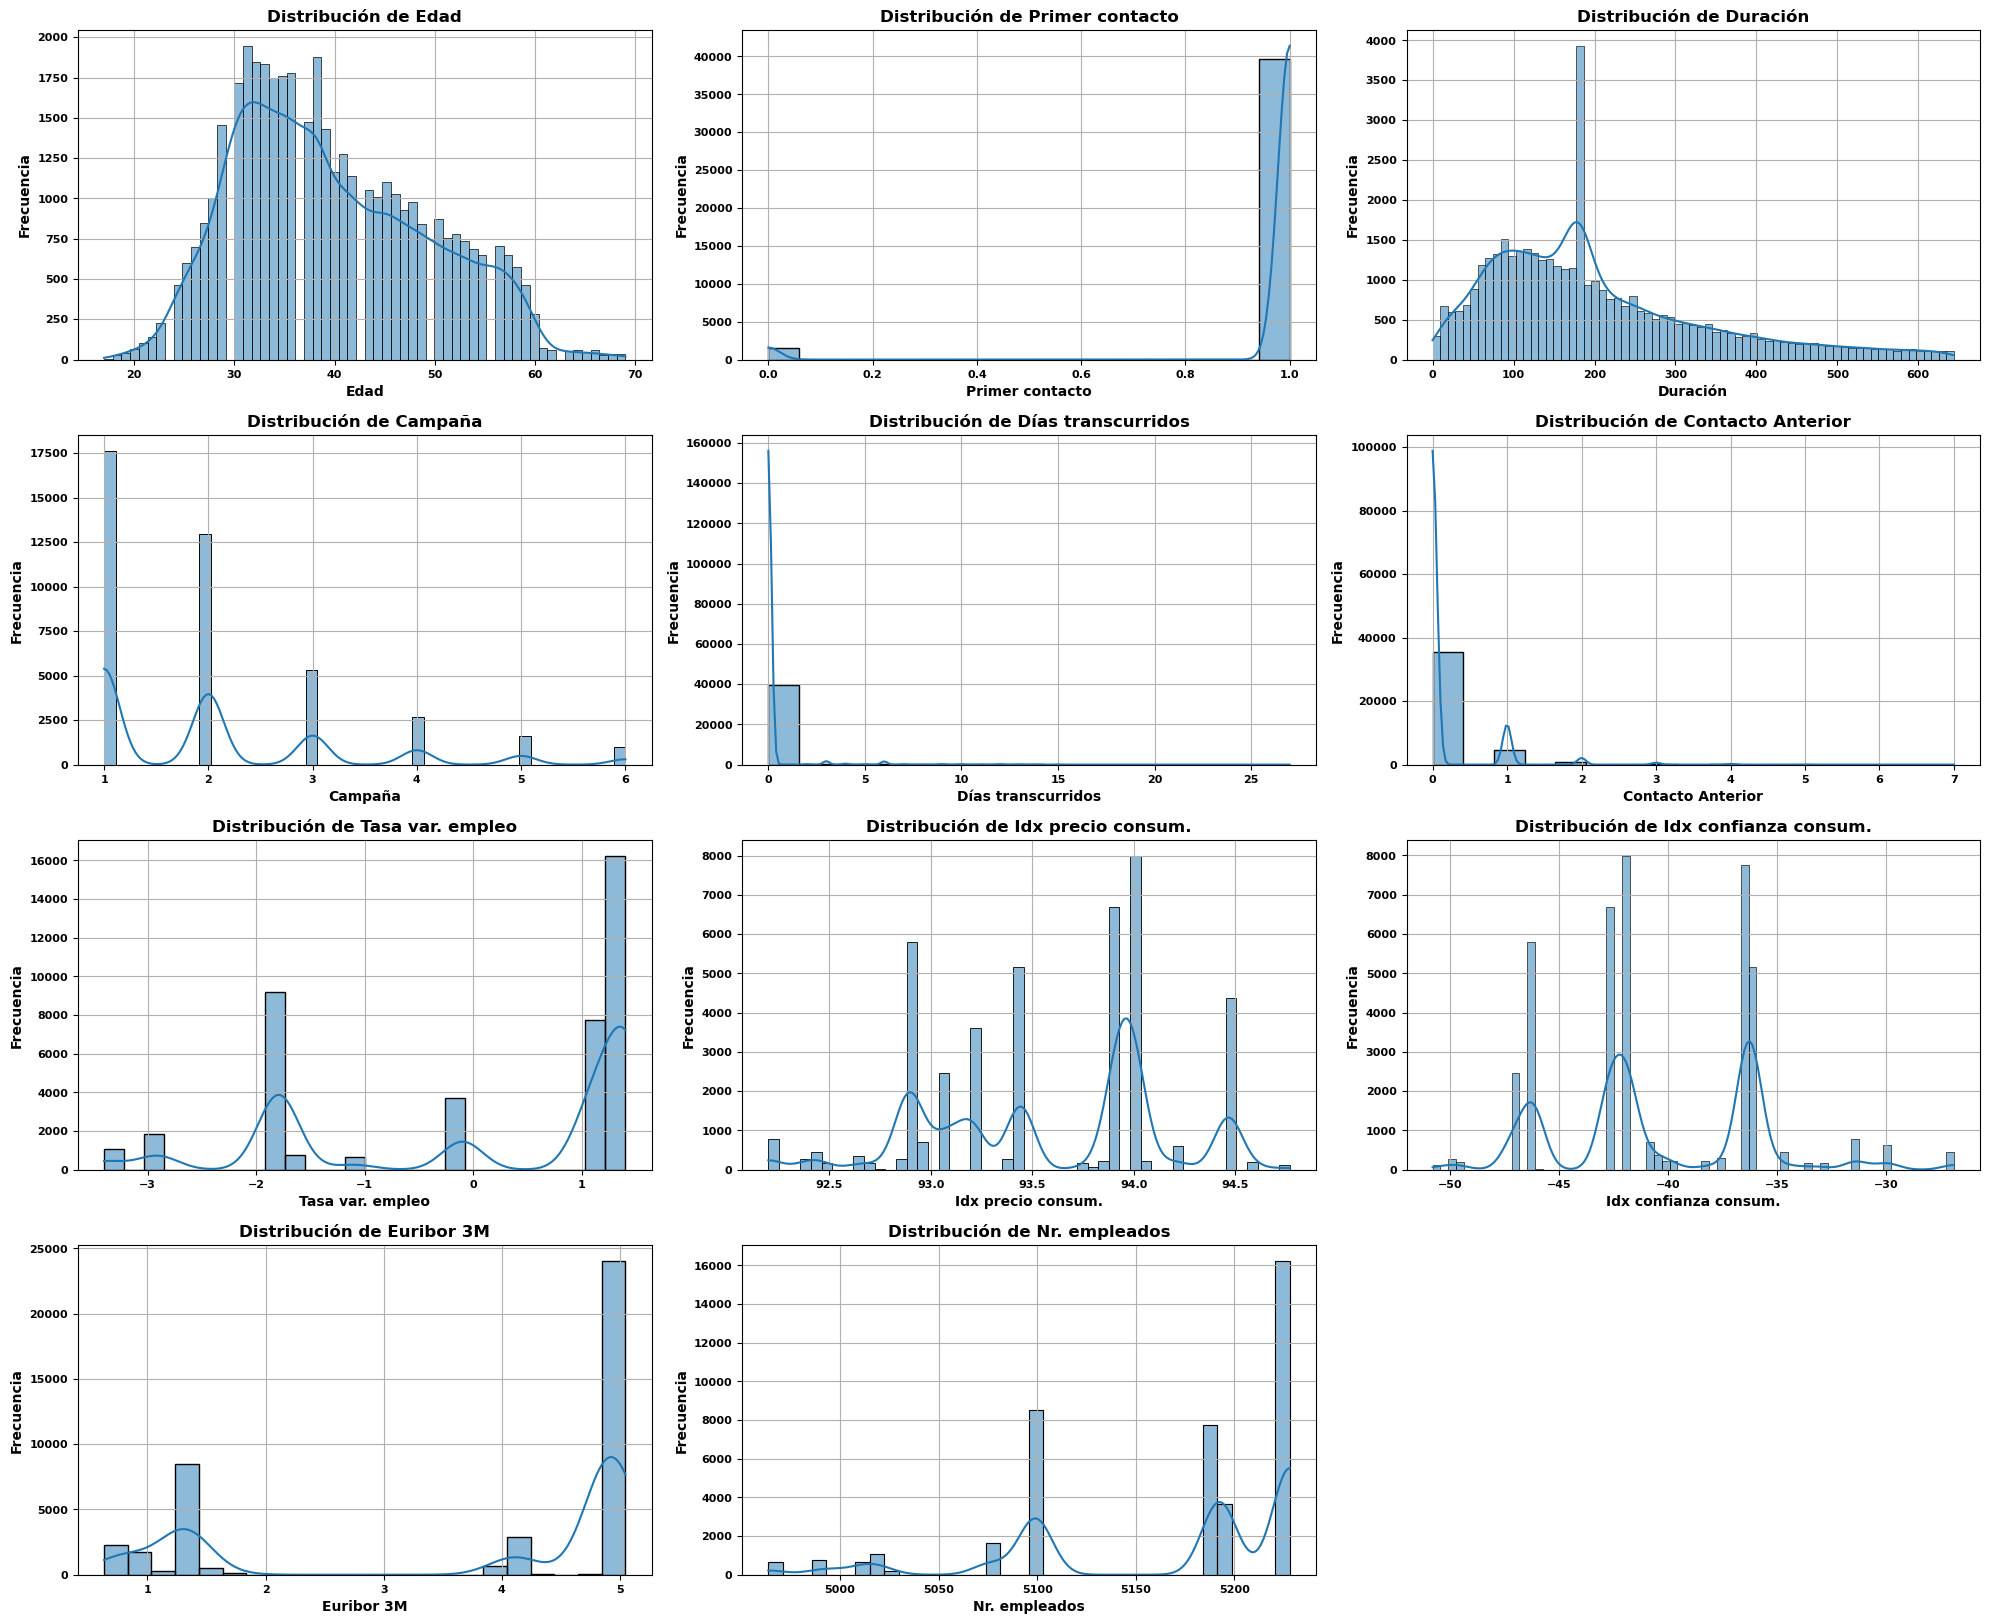

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(20, 20))
cols = len(numeric_columns)
num_cols = 3
num_rows = round(cols/num_cols)+1
for i, col in enumerate(numeric_columns):
    plt.subplot(num_rows, num_cols, i+1)  
    plt.title(f"Distribución de {col}")
    sns.histplot(df[col], kde=True)
    plt.xlabel(col)  
    plt.ylabel('Frecuencia')  
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8)  
    plt.grid(True)  

plt.tight_layout()  
plt.show()

Se puede observar la distribución de la "Edad" tendiendo a normal. La distribución de "Duración" todavía tiene un sesgo a derecha bastante pronunciado y un pico importante en 180 debido a la importación de la mediana.
La distribución de "Primer contacto" muestra que casi en su totalidad los valores representan al primer contacto de un cliente.
Las distribuciones de "Días transcurridos" y "Contacto anterior" muestrar que su valor mas frecuente esta en 0.
La distribución de "Campaña" muestra que el primer y segundo contacto son los valores predominantes.

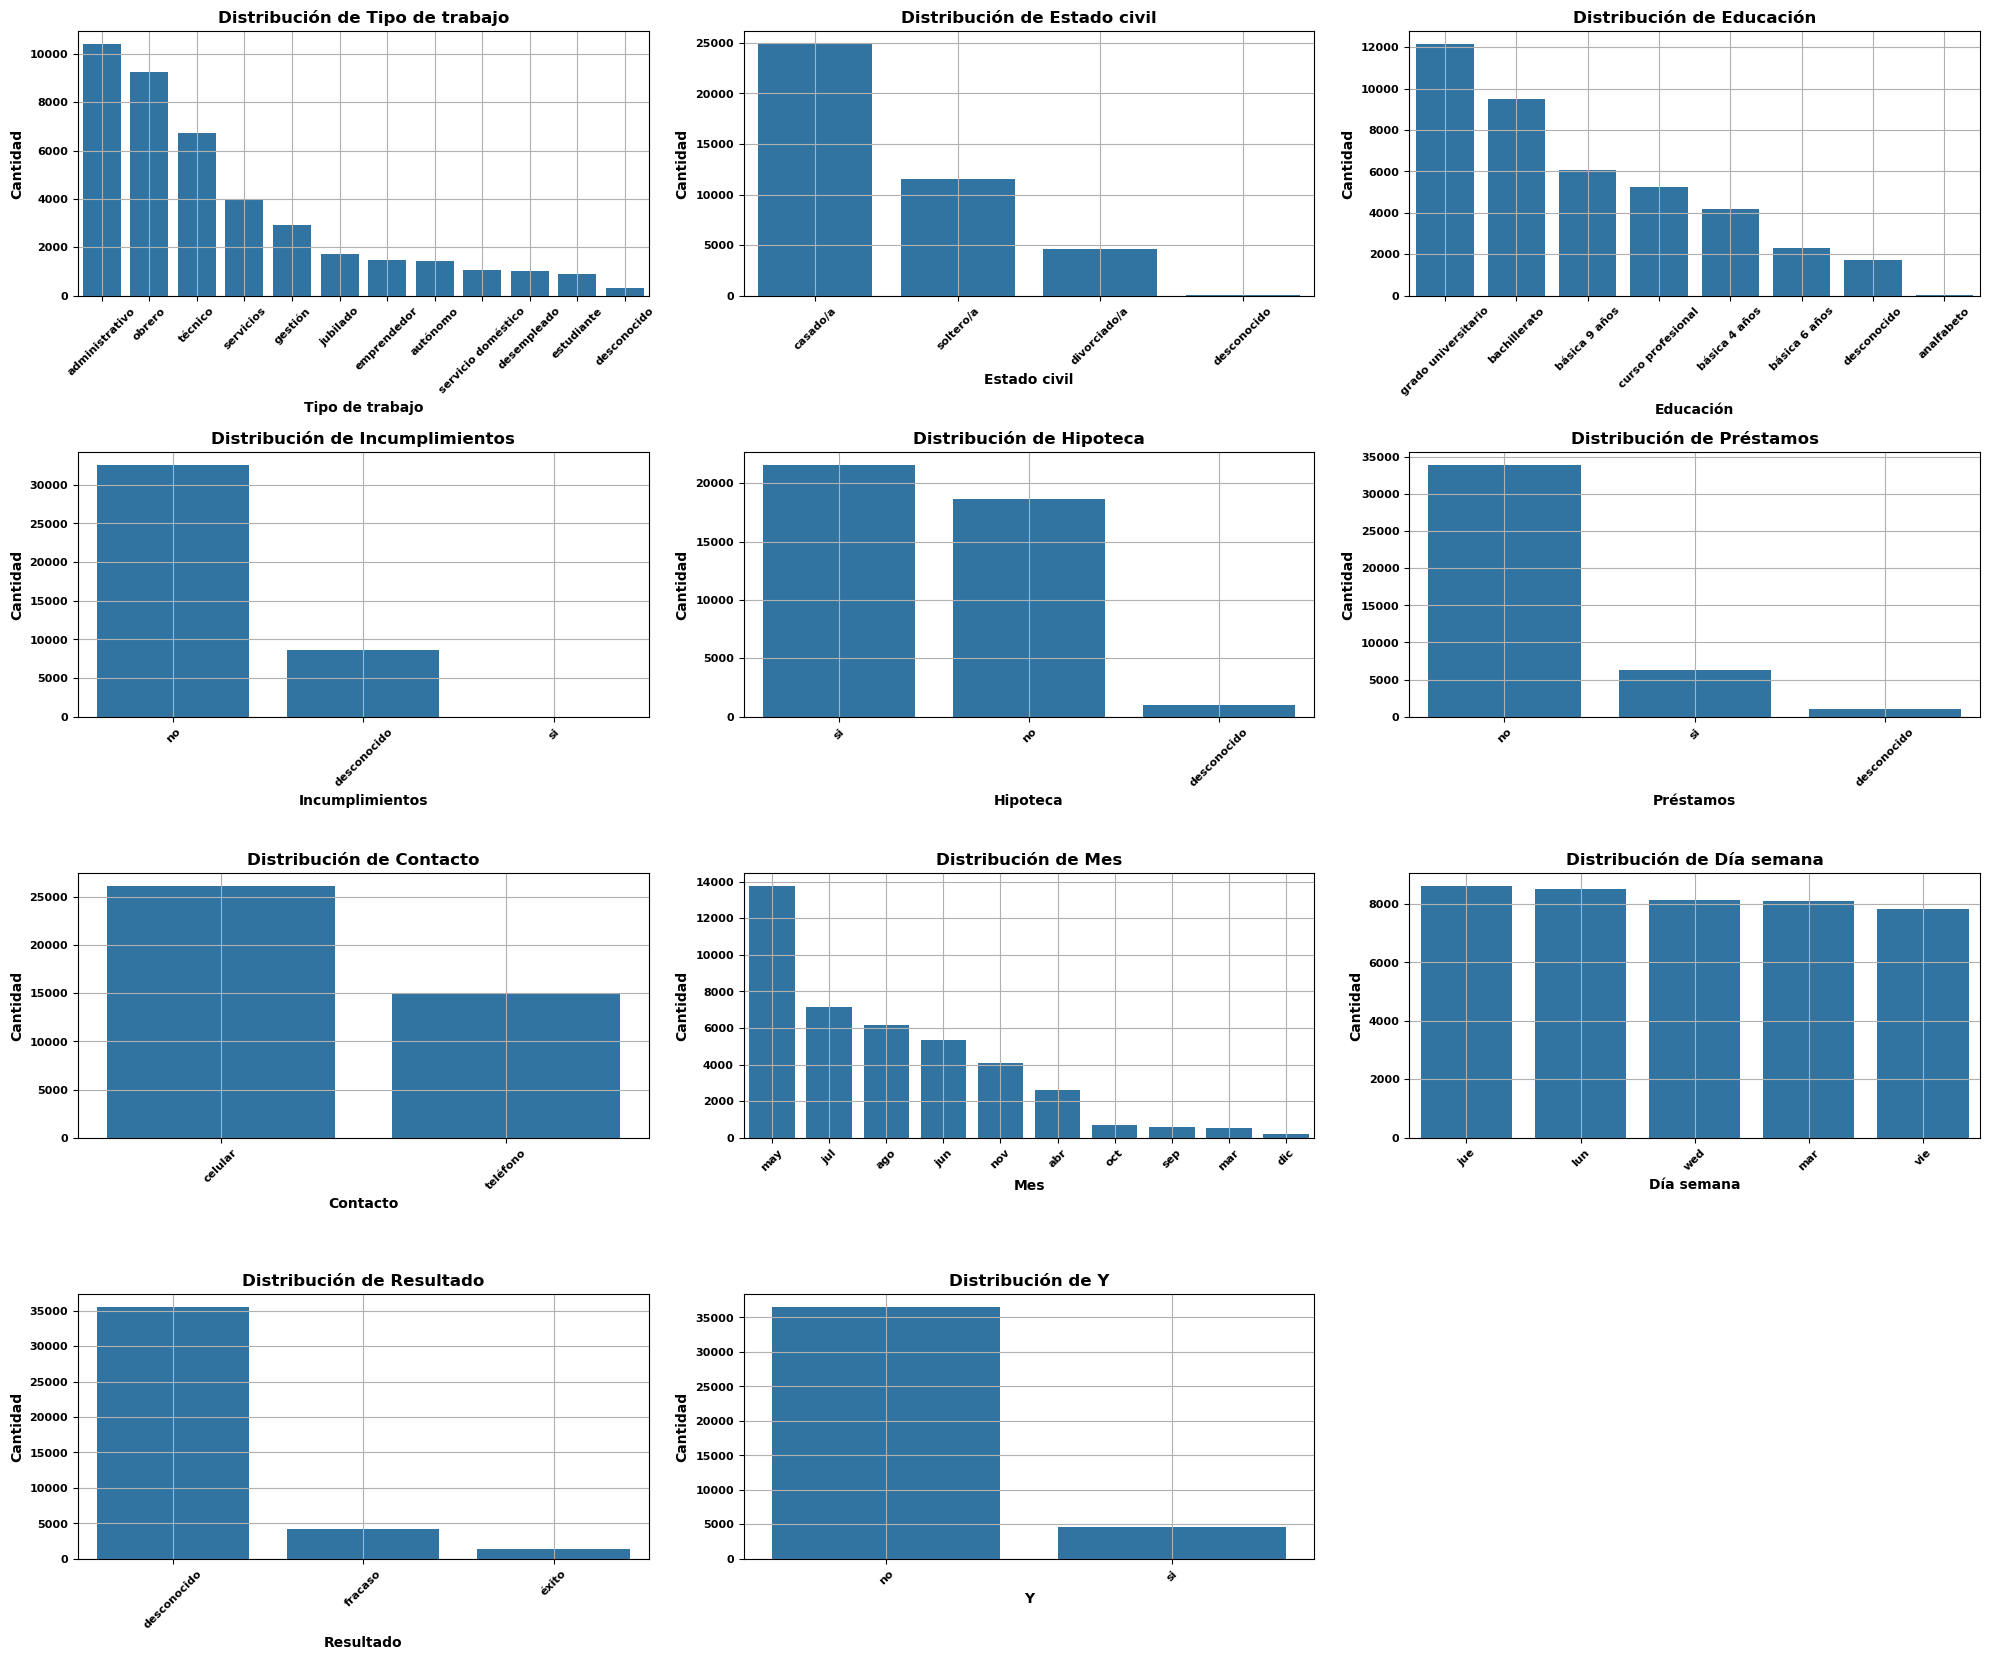

In [363]:
categorical_columns = df.select_dtypes(['object']).columns

plt.figure(figsize=(20, 20))
cols = len(categorical_columns)
num_cols = 3
num_rows = round(cols/num_cols)+1
for i, col in enumerate(categorical_columns):
    plt.subplot(num_rows, num_cols, i+1)  
    plt.title(f"Distribución de {col}")
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xlabel(col)  
    plt.ylabel('Cantidad')
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8)
    plt.xticks(rotation=45)  
    plt.grid(True)  

plt.tight_layout()  
plt.show()

En cuanto a las variables categóricas podemos ver que:
Para el caso de "Tipo de trabajo" los valores que abarcan el mayor porcentaje son "administrativo", "obrero" y "técnico".
En el caso de "Estado civil" el valor de Casado dobla al de soltero.
En cuanto a "Educación" los niveles mas predominantes son el grado universitario y bachillerato, analfabetos no se muestran.
En cuanto a "Incumplimientos" la gran mayoría no presenta, sin embargo la gran mayoría tampoco tiene préstamos.
Para el caso de "Hipotecas" se ve distribuido en casi un 50%.
El medio de contacto mas frecuente fue el celular, casi doblando al teléfono fijo.
El mes mas fuerte de la campaña fue en mayo, en cuanto a los días se realizó parejo de Lunes a Viernes.
En cuanto a los resultados, el "Resultado" que indica resultados de una campaña anterior el dato mas frecuente es "desconocido", con lo cual resulta dificil un seguimiento. 
Finalmente para la variable target "Y" alrededor de un 80% indica que no suscribiría a un plazo fijo.

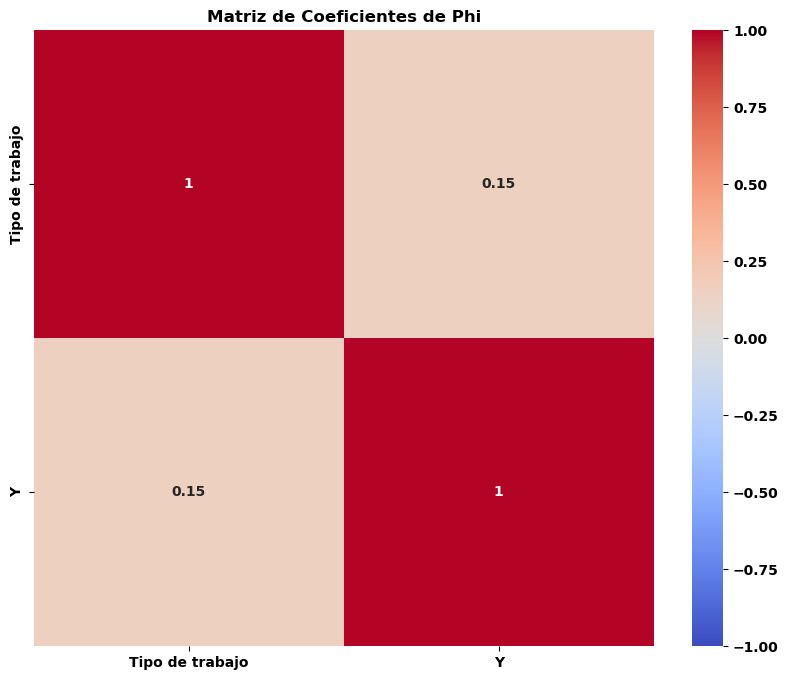

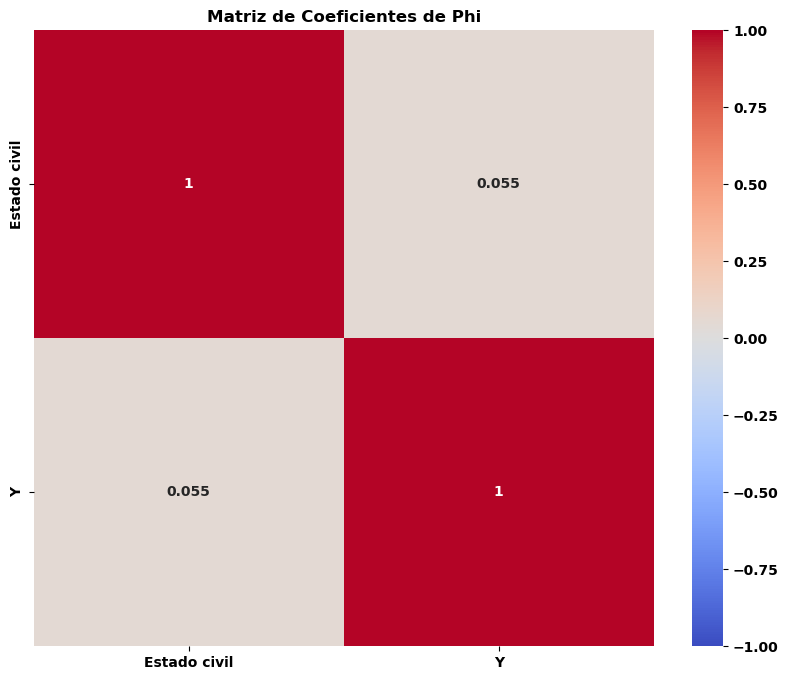

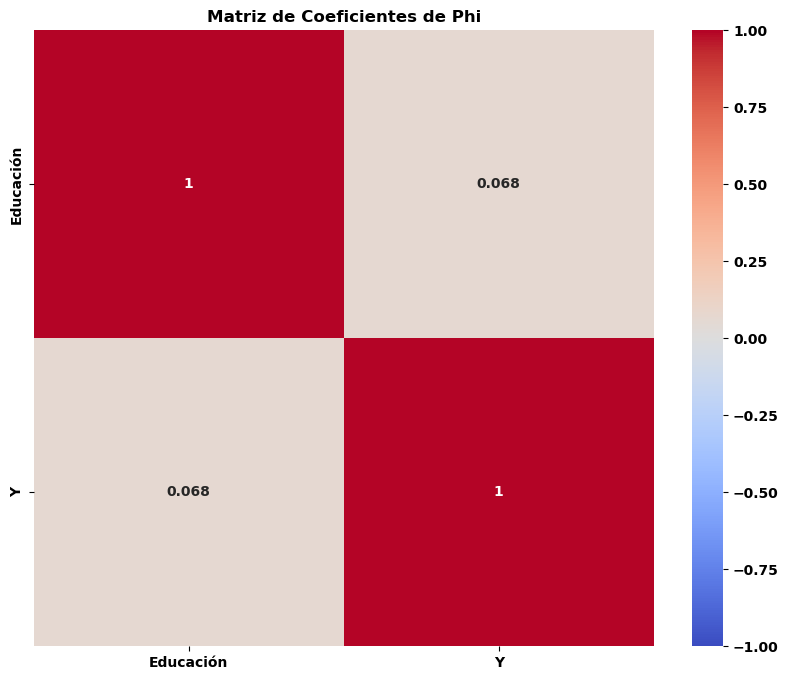

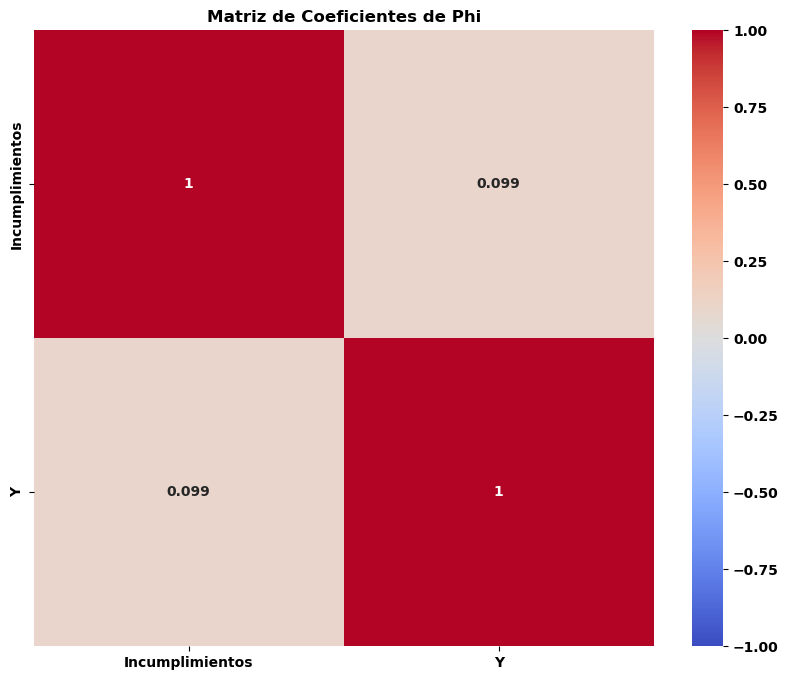

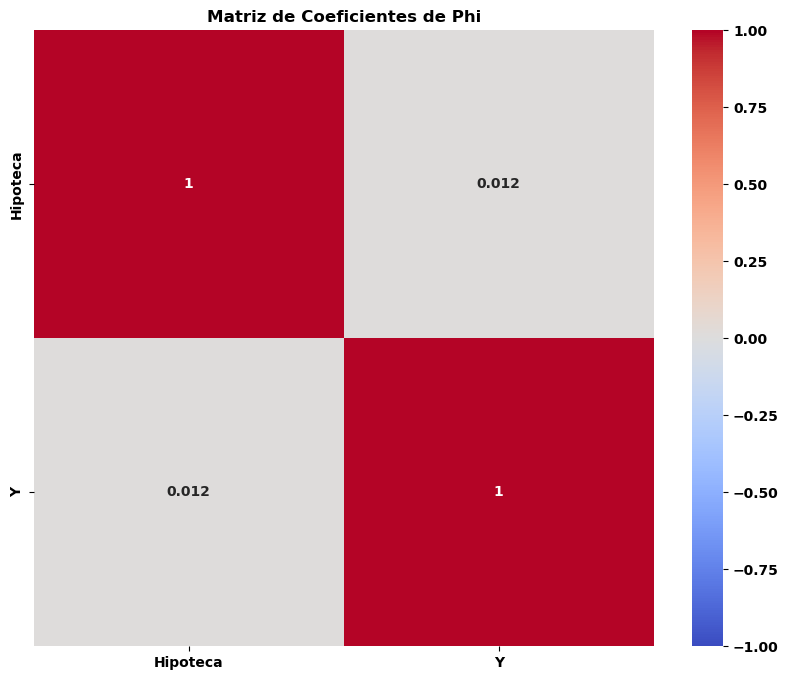

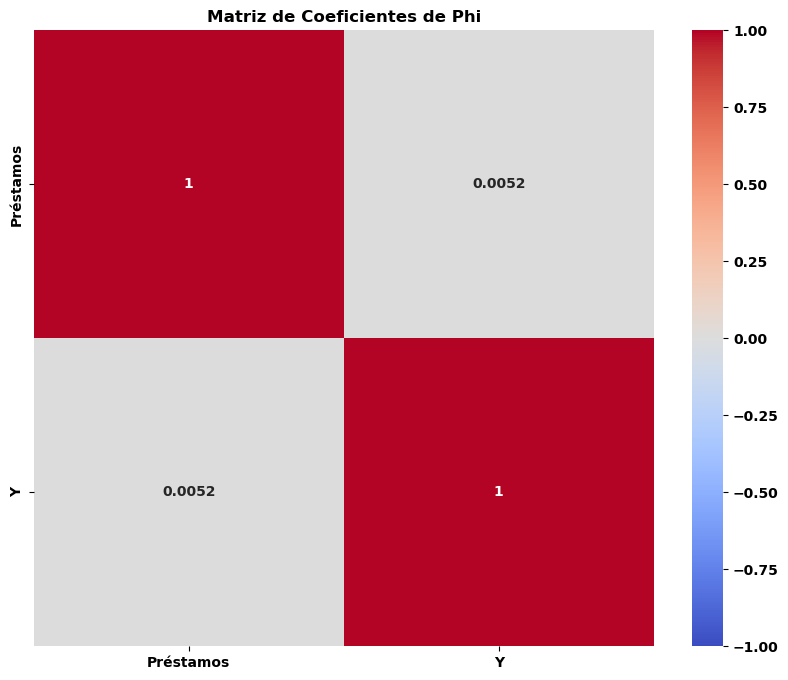

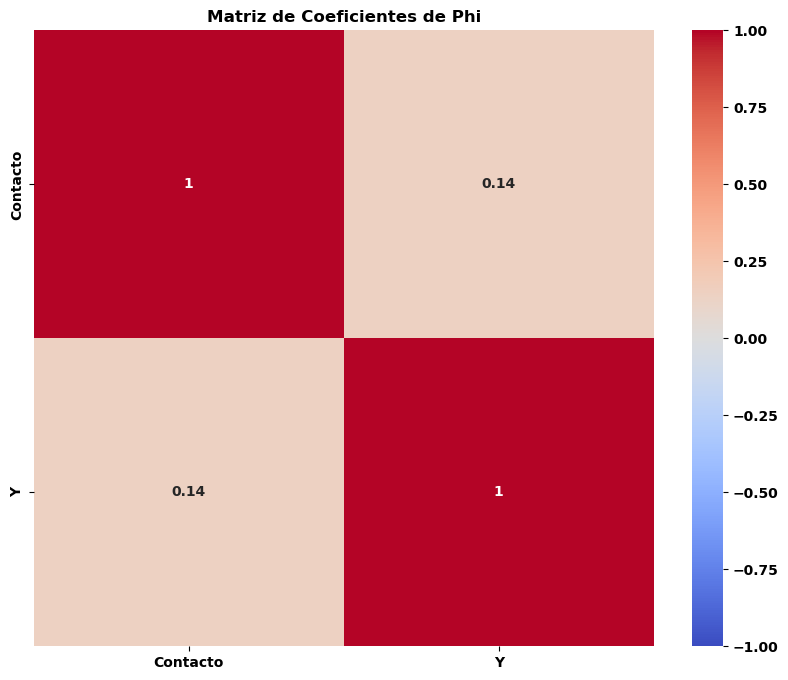

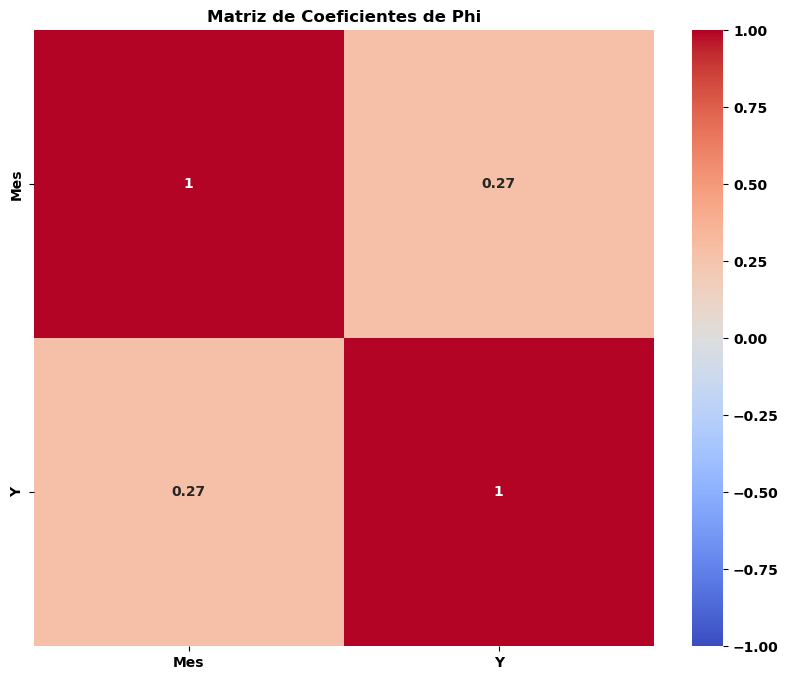

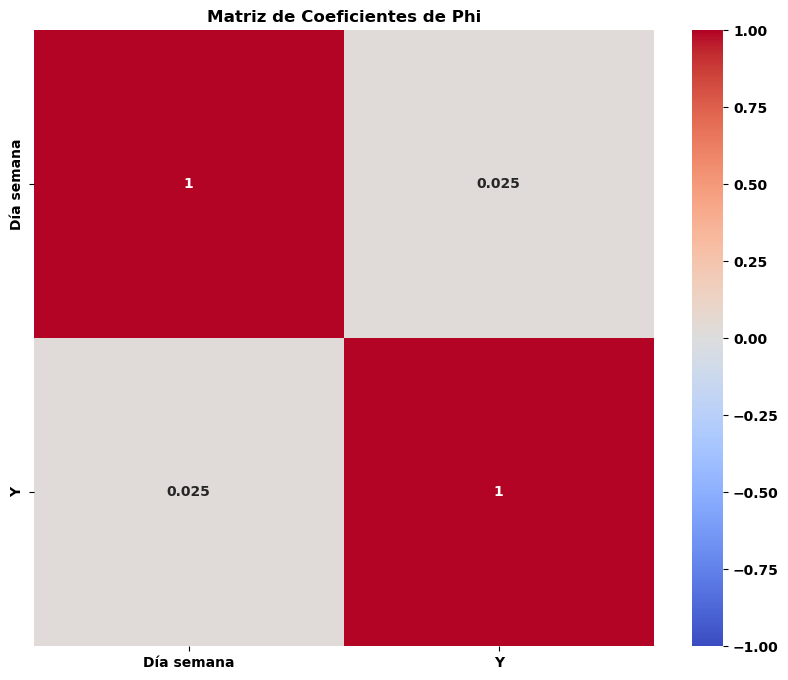

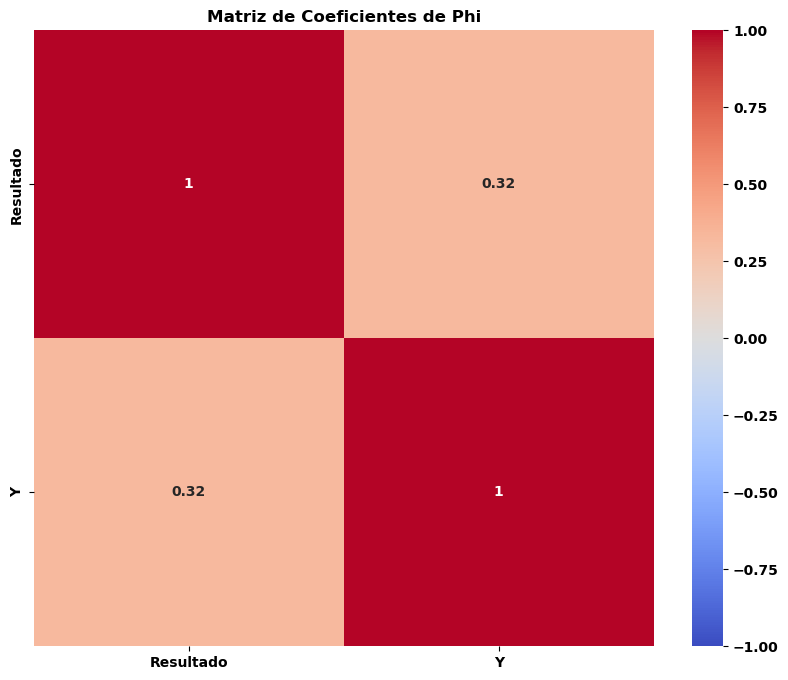

In [365]:
from scipy.stats import chi2_contingency

categorical_columns = df.select_dtypes(['object']).columns
categorical_columns = categorical_columns.drop('Y')

for col in categorical_columns:
    col1=col
    col2=Col.Y

    contingency_table = pd.crosstab(df[col1], df[col2])

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    phi_coefficient = np.sqrt(chi2 / df.shape[0])

    cols = [col1, col2]  
    phi_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i != j:
                table = pd.crosstab(df[cols[i]], df[cols[j]])
                chi2, p, dof, expected = chi2_contingency(table)
                phi_matrix.iloc[i, j] = np.sqrt(chi2 / df.shape[0])
            else:
                phi_matrix.iloc[i, j] = 1 

    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(phi_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matriz de Coeficientes de Phi')
    plt.show()

No se encuentra ninguna relación clara entre la variable target y las columnas categóricas.

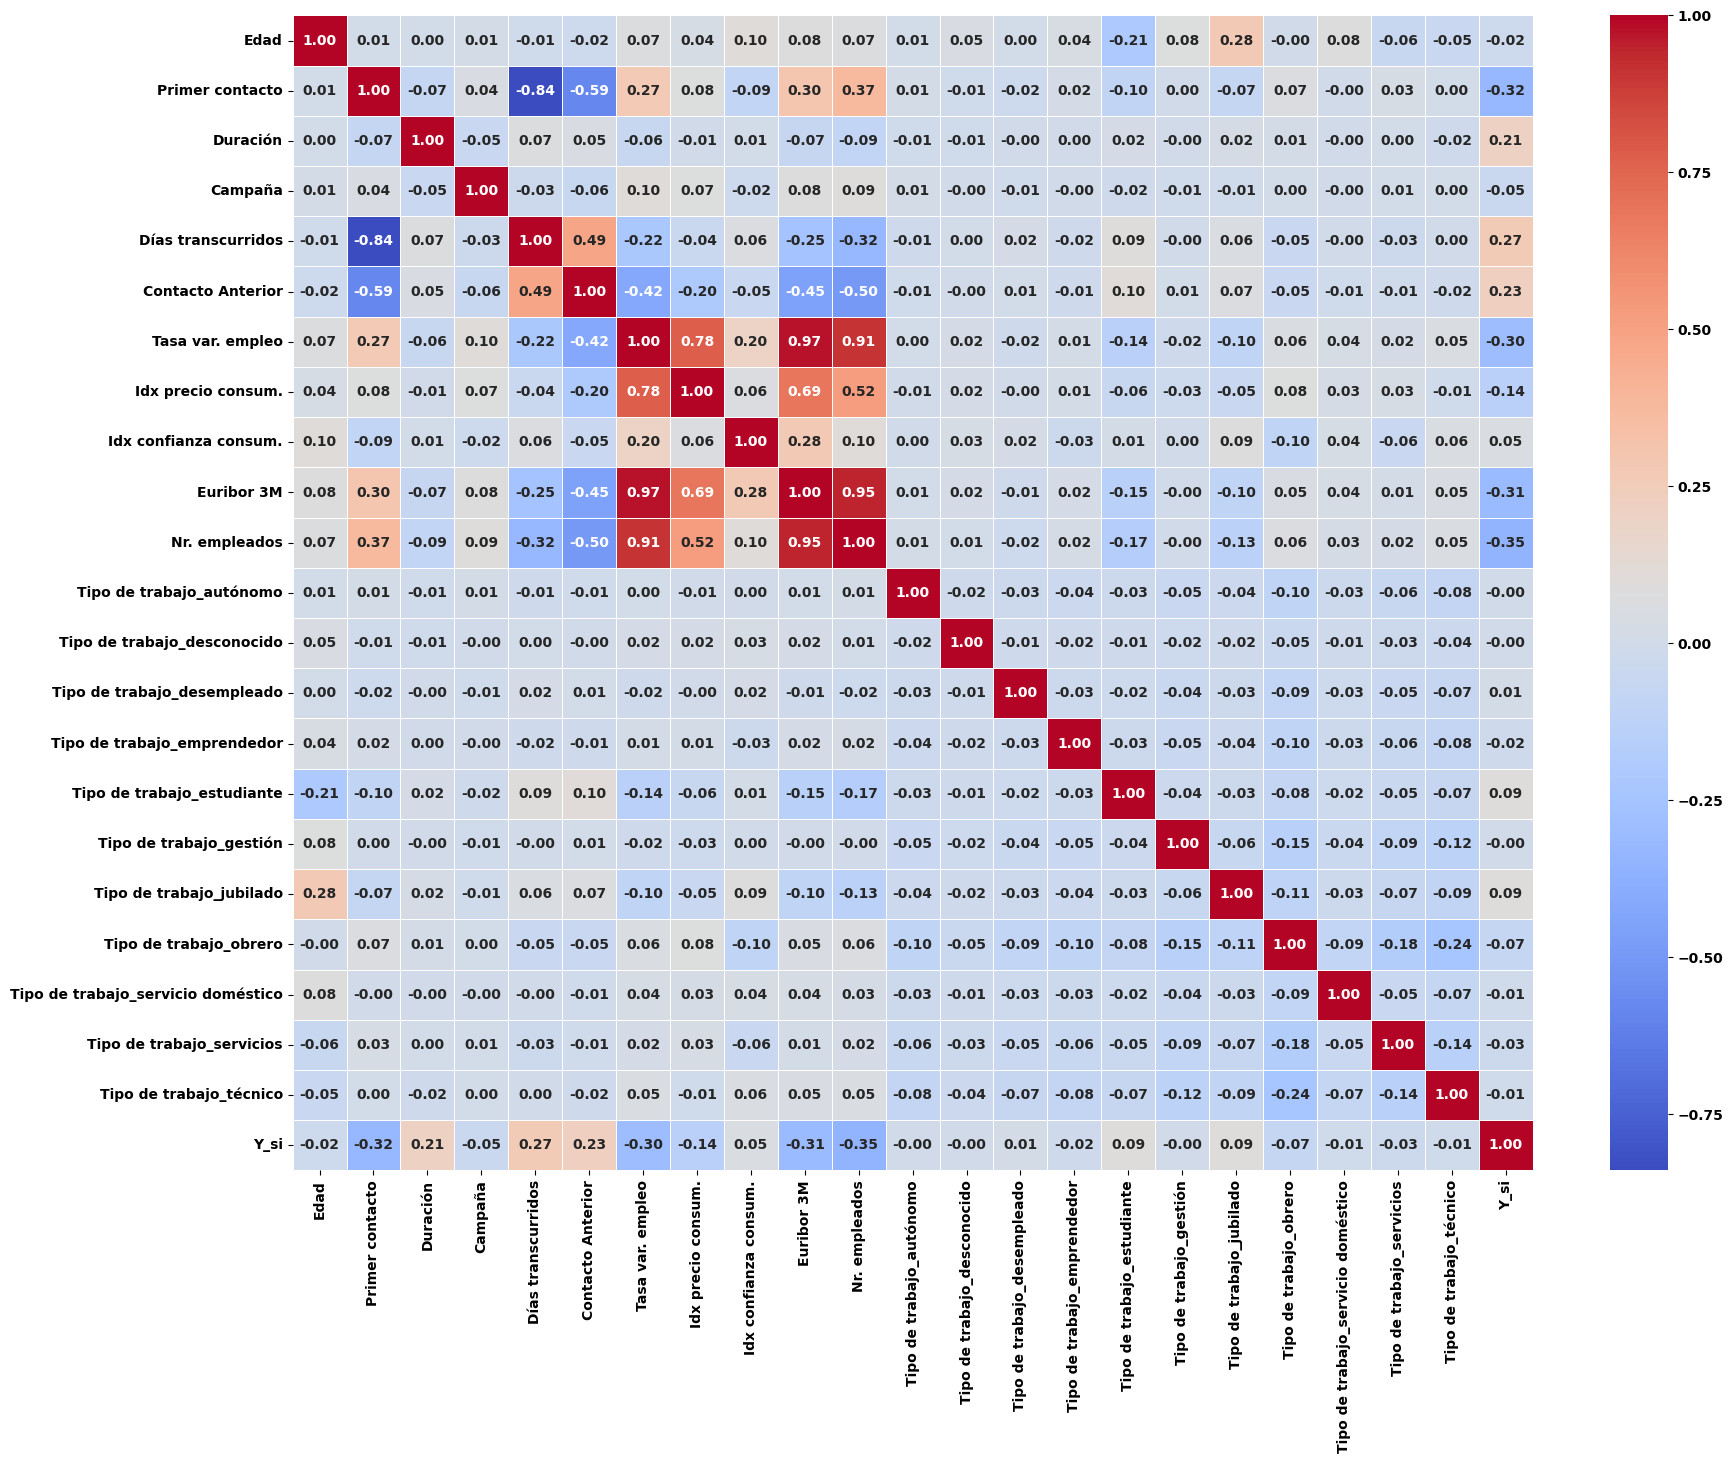

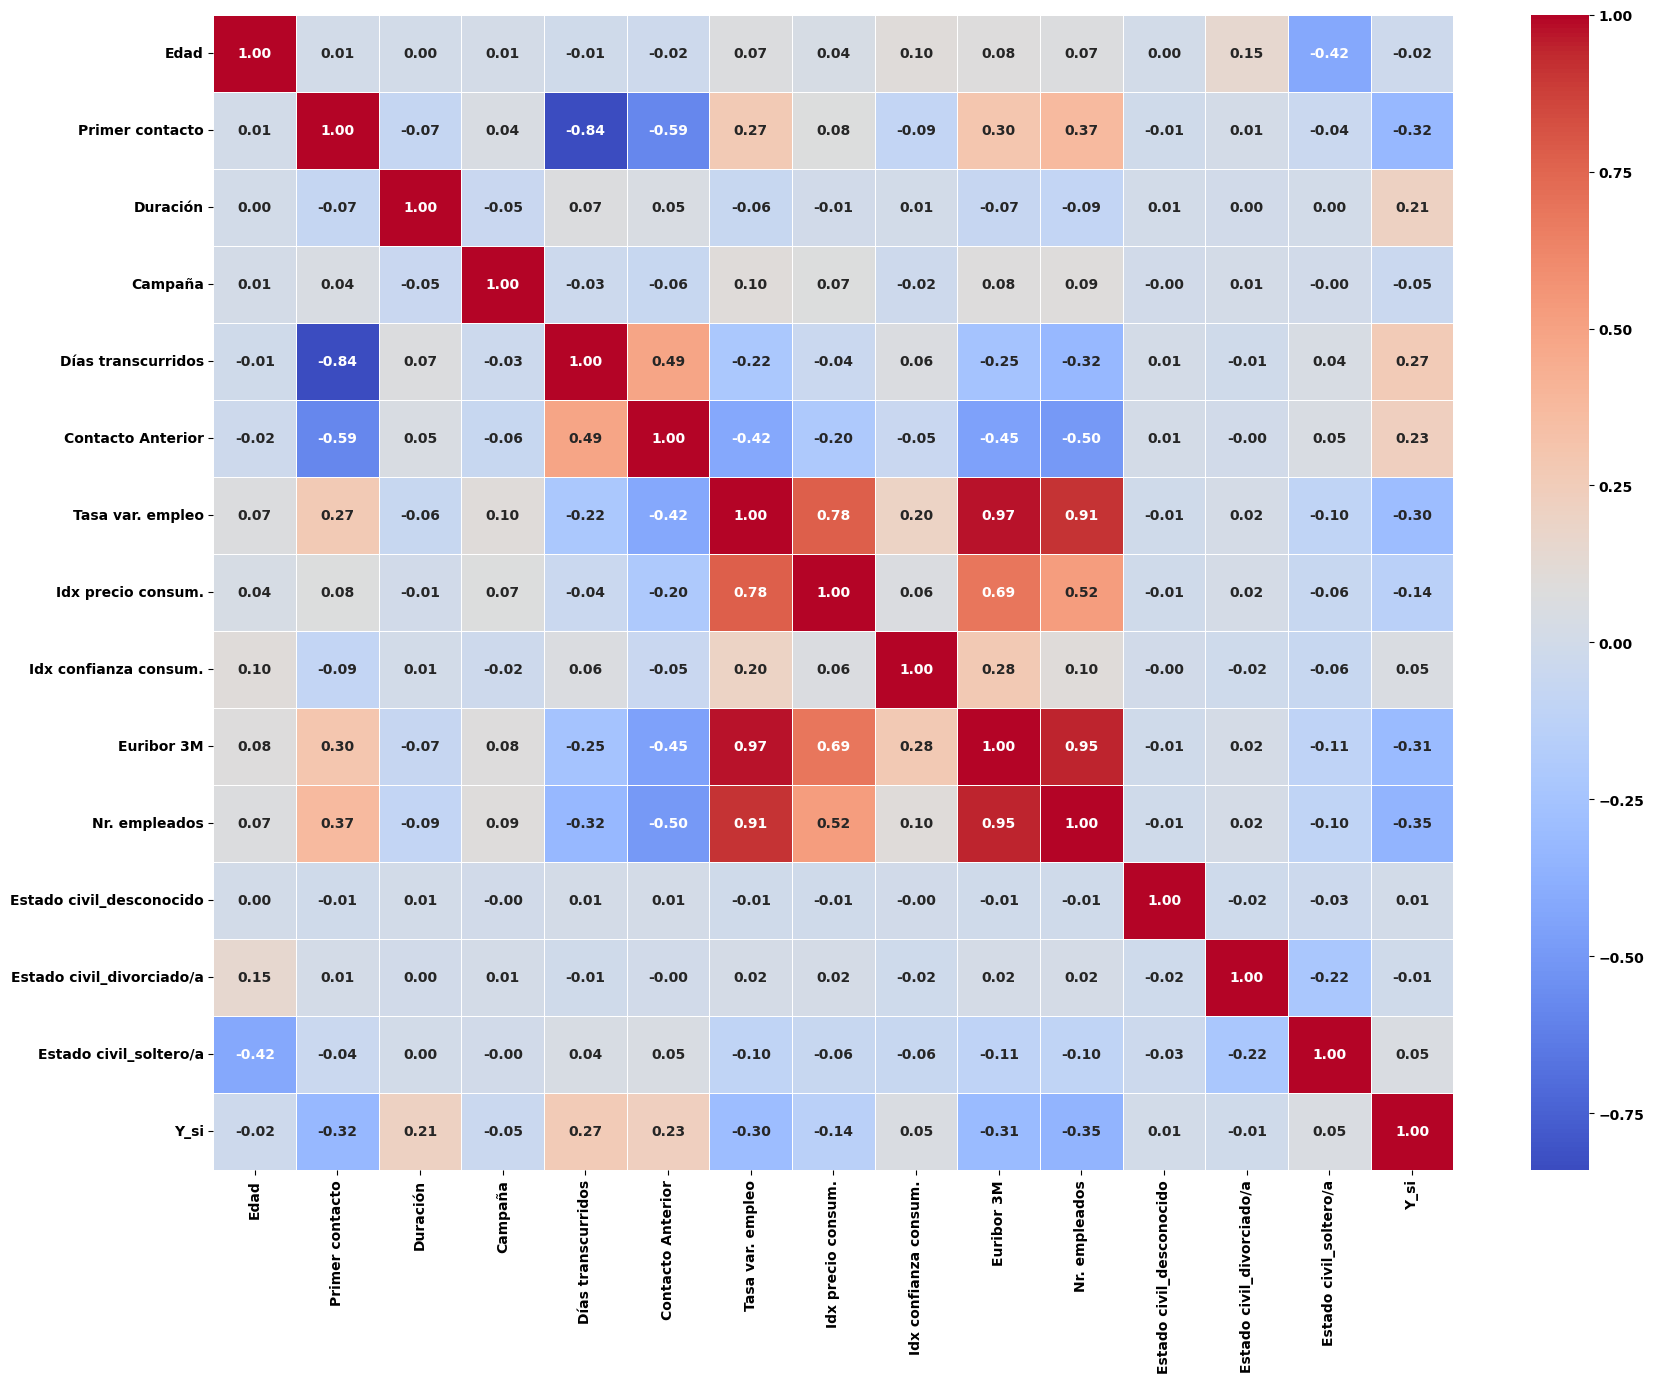

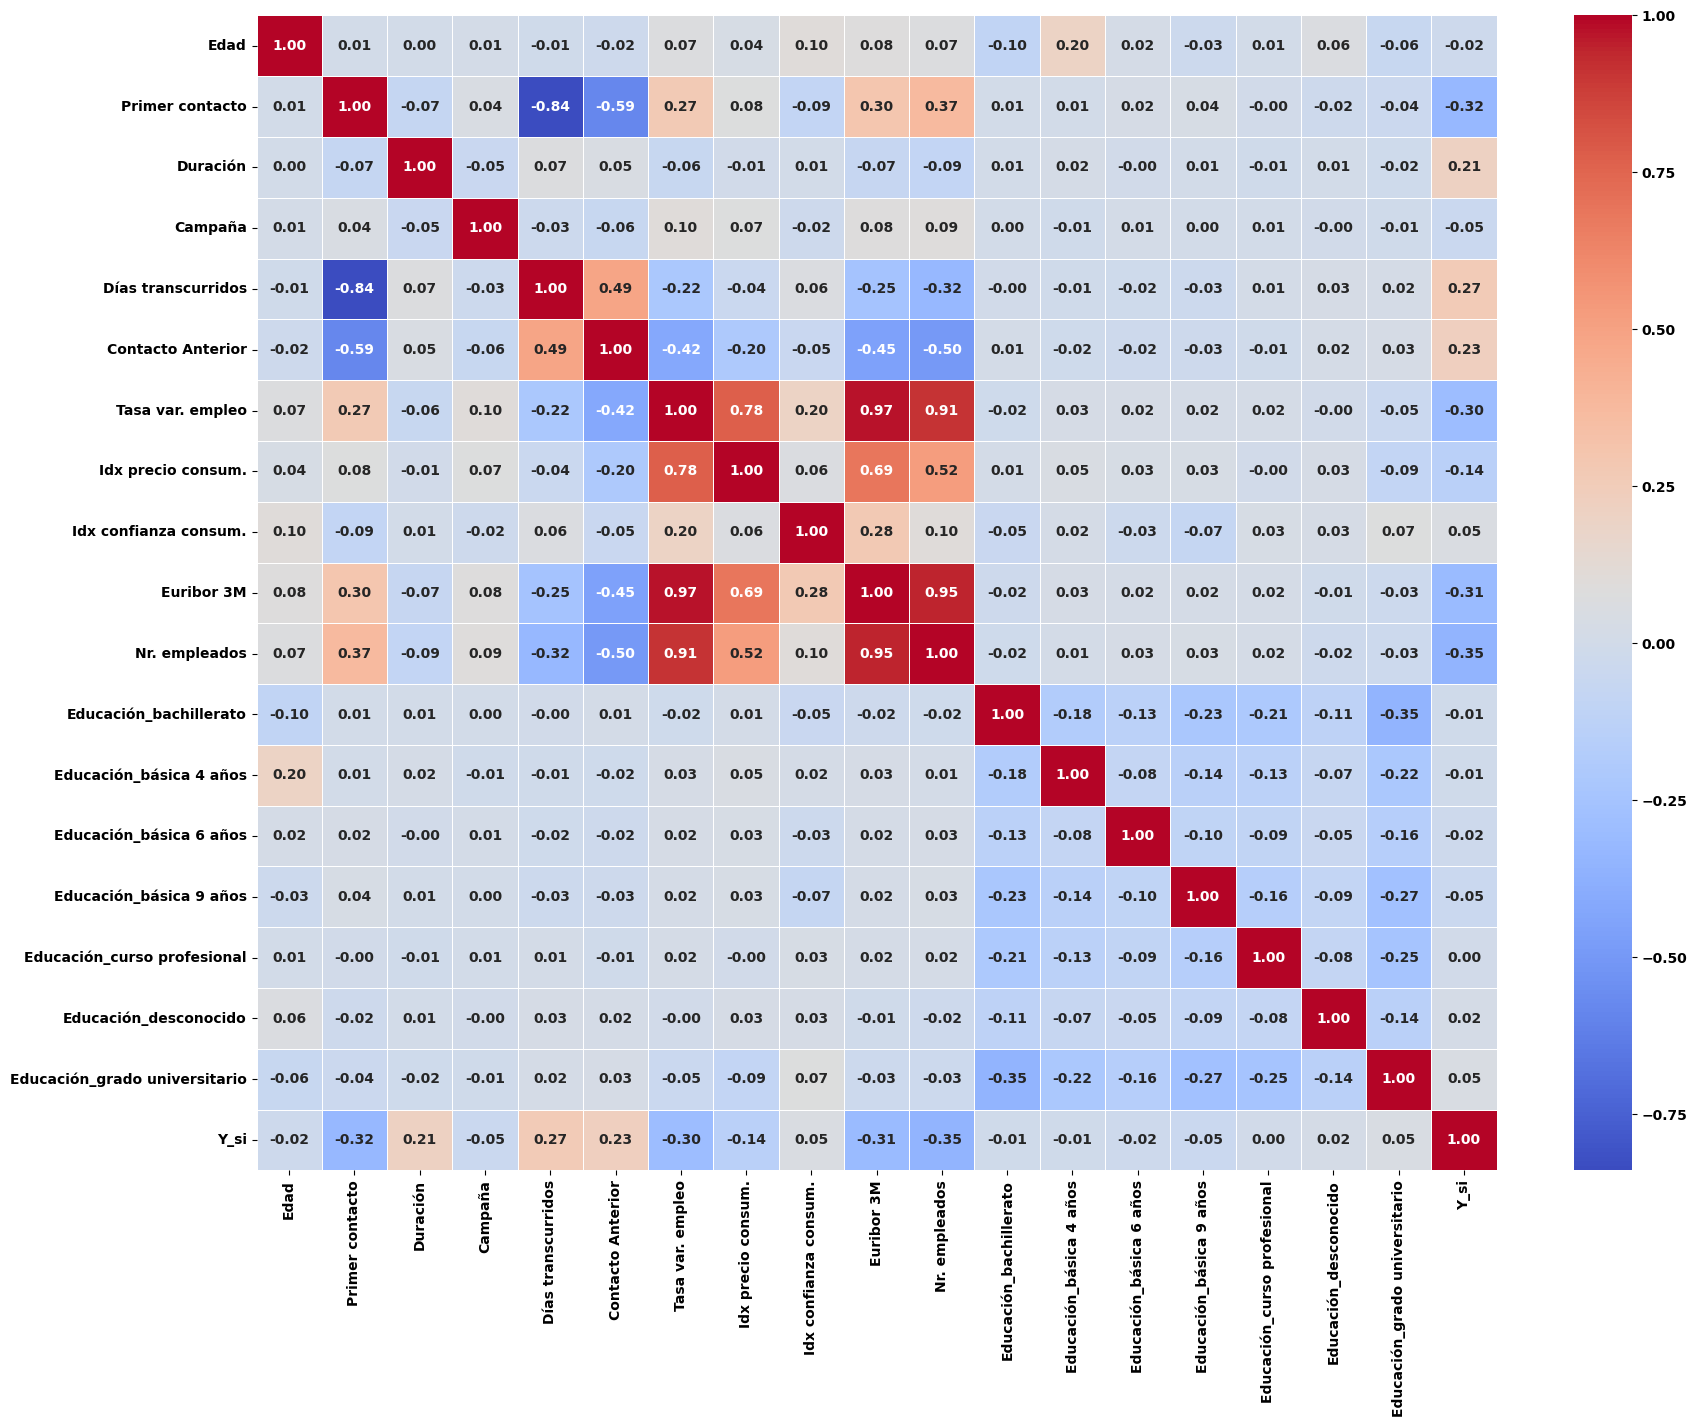

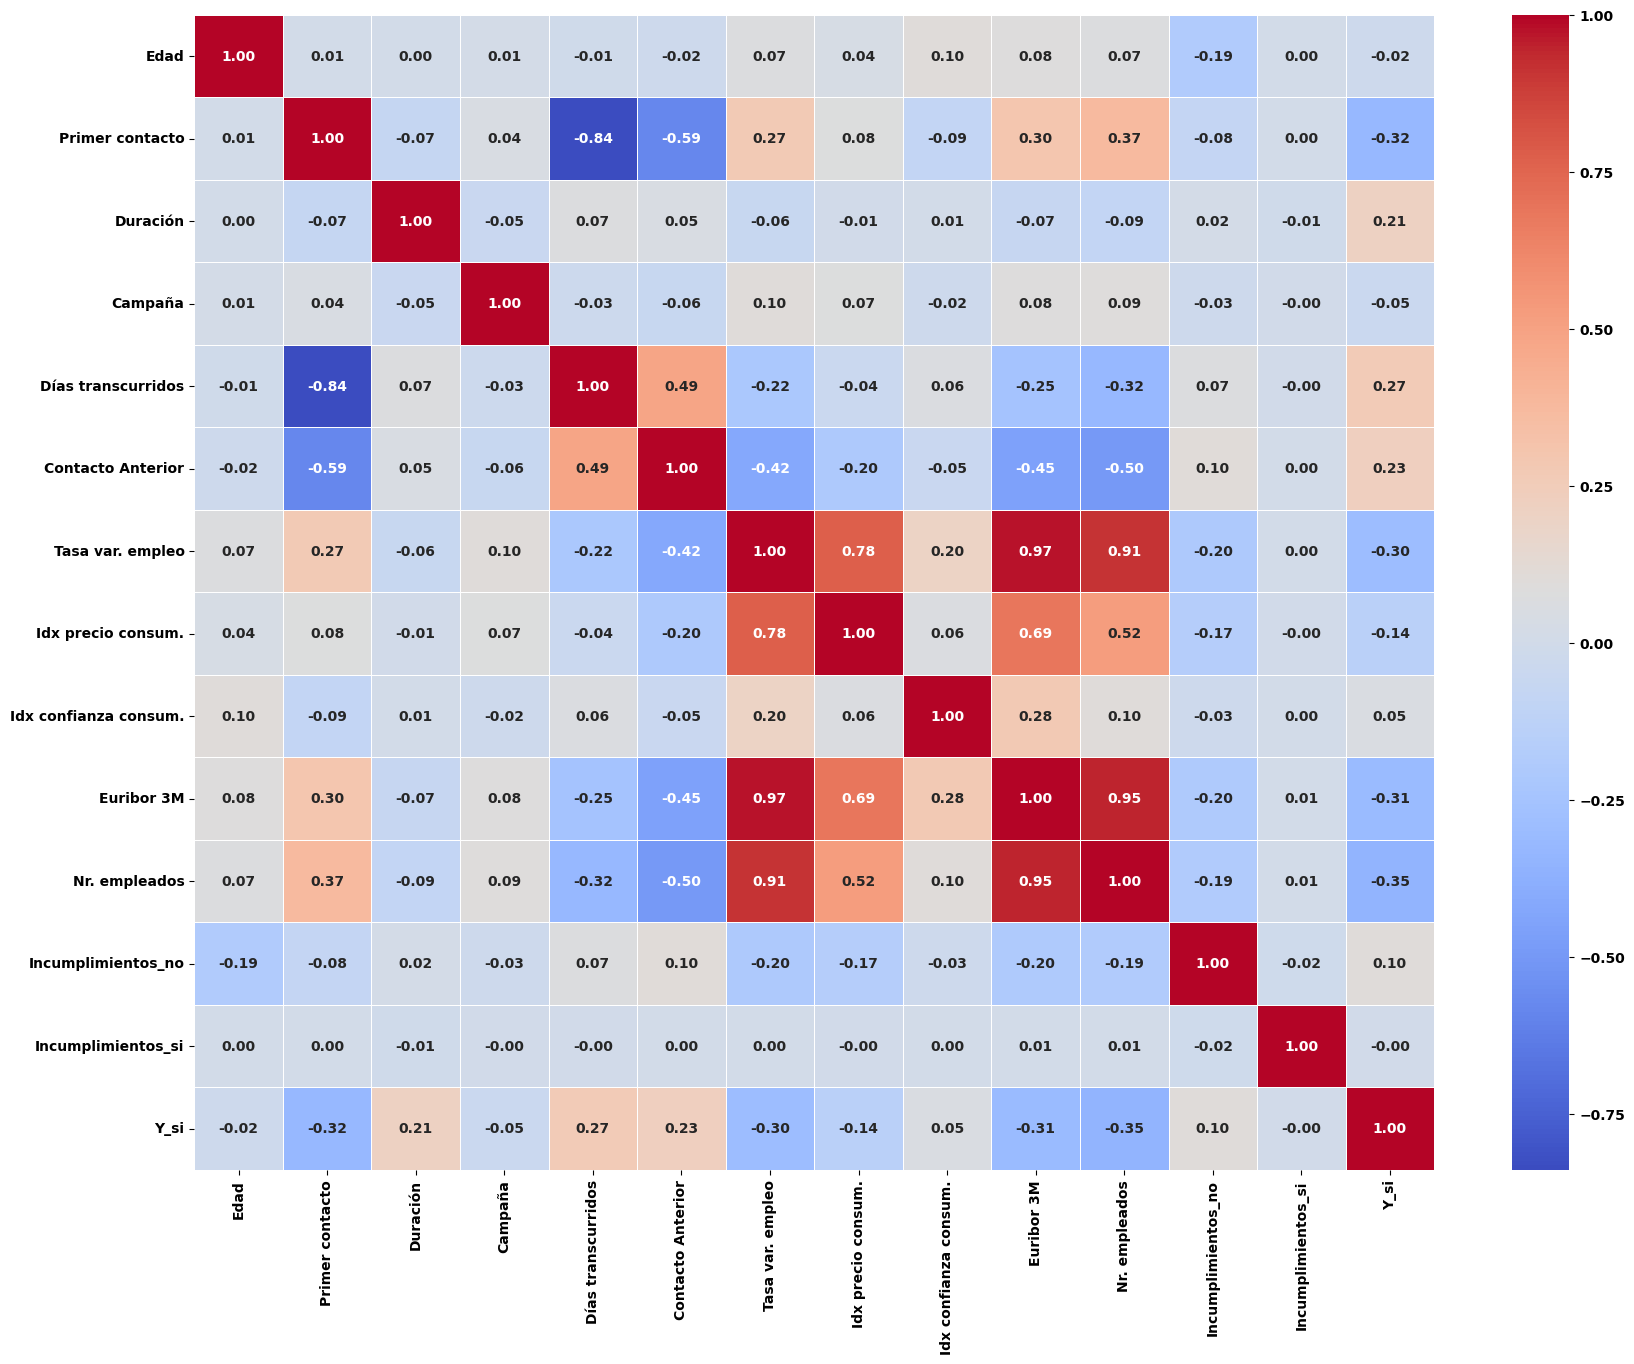

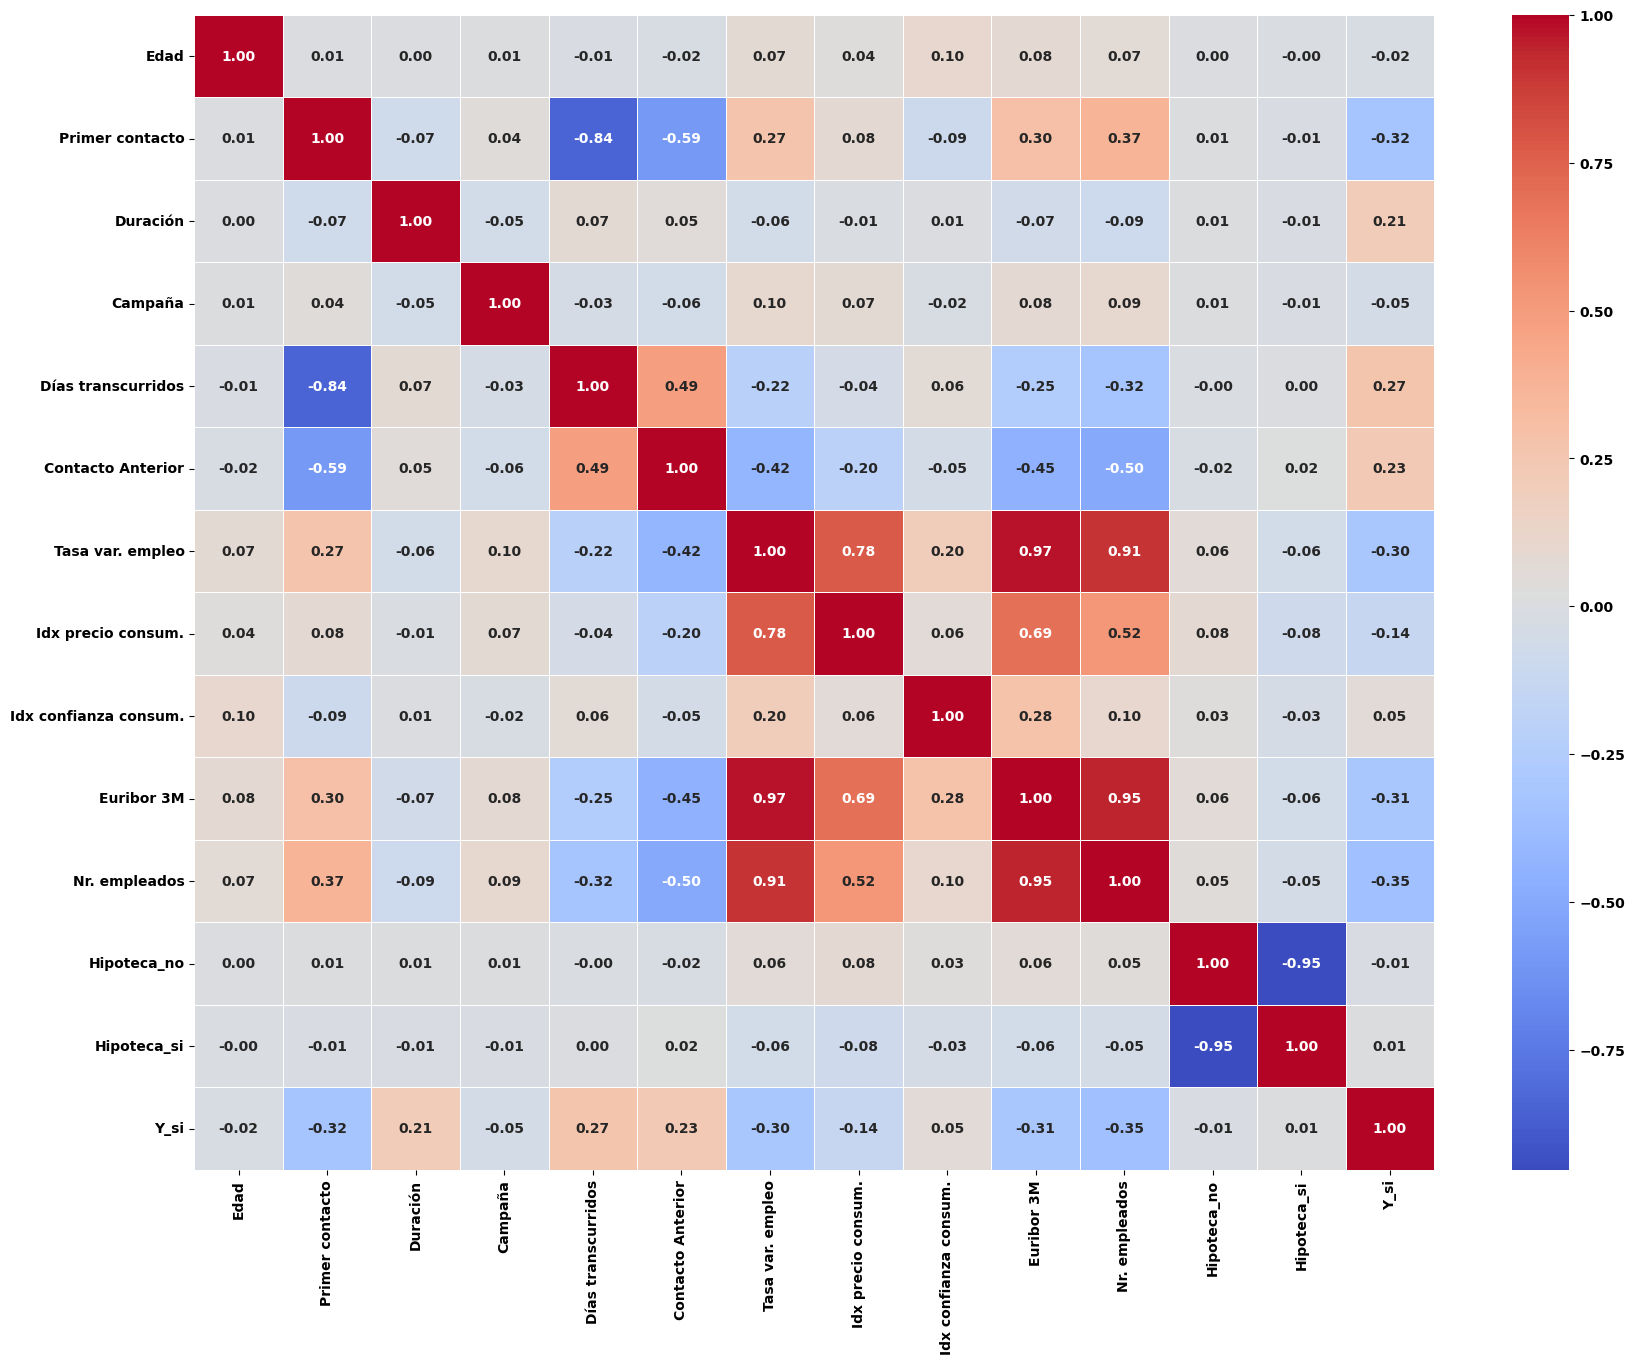

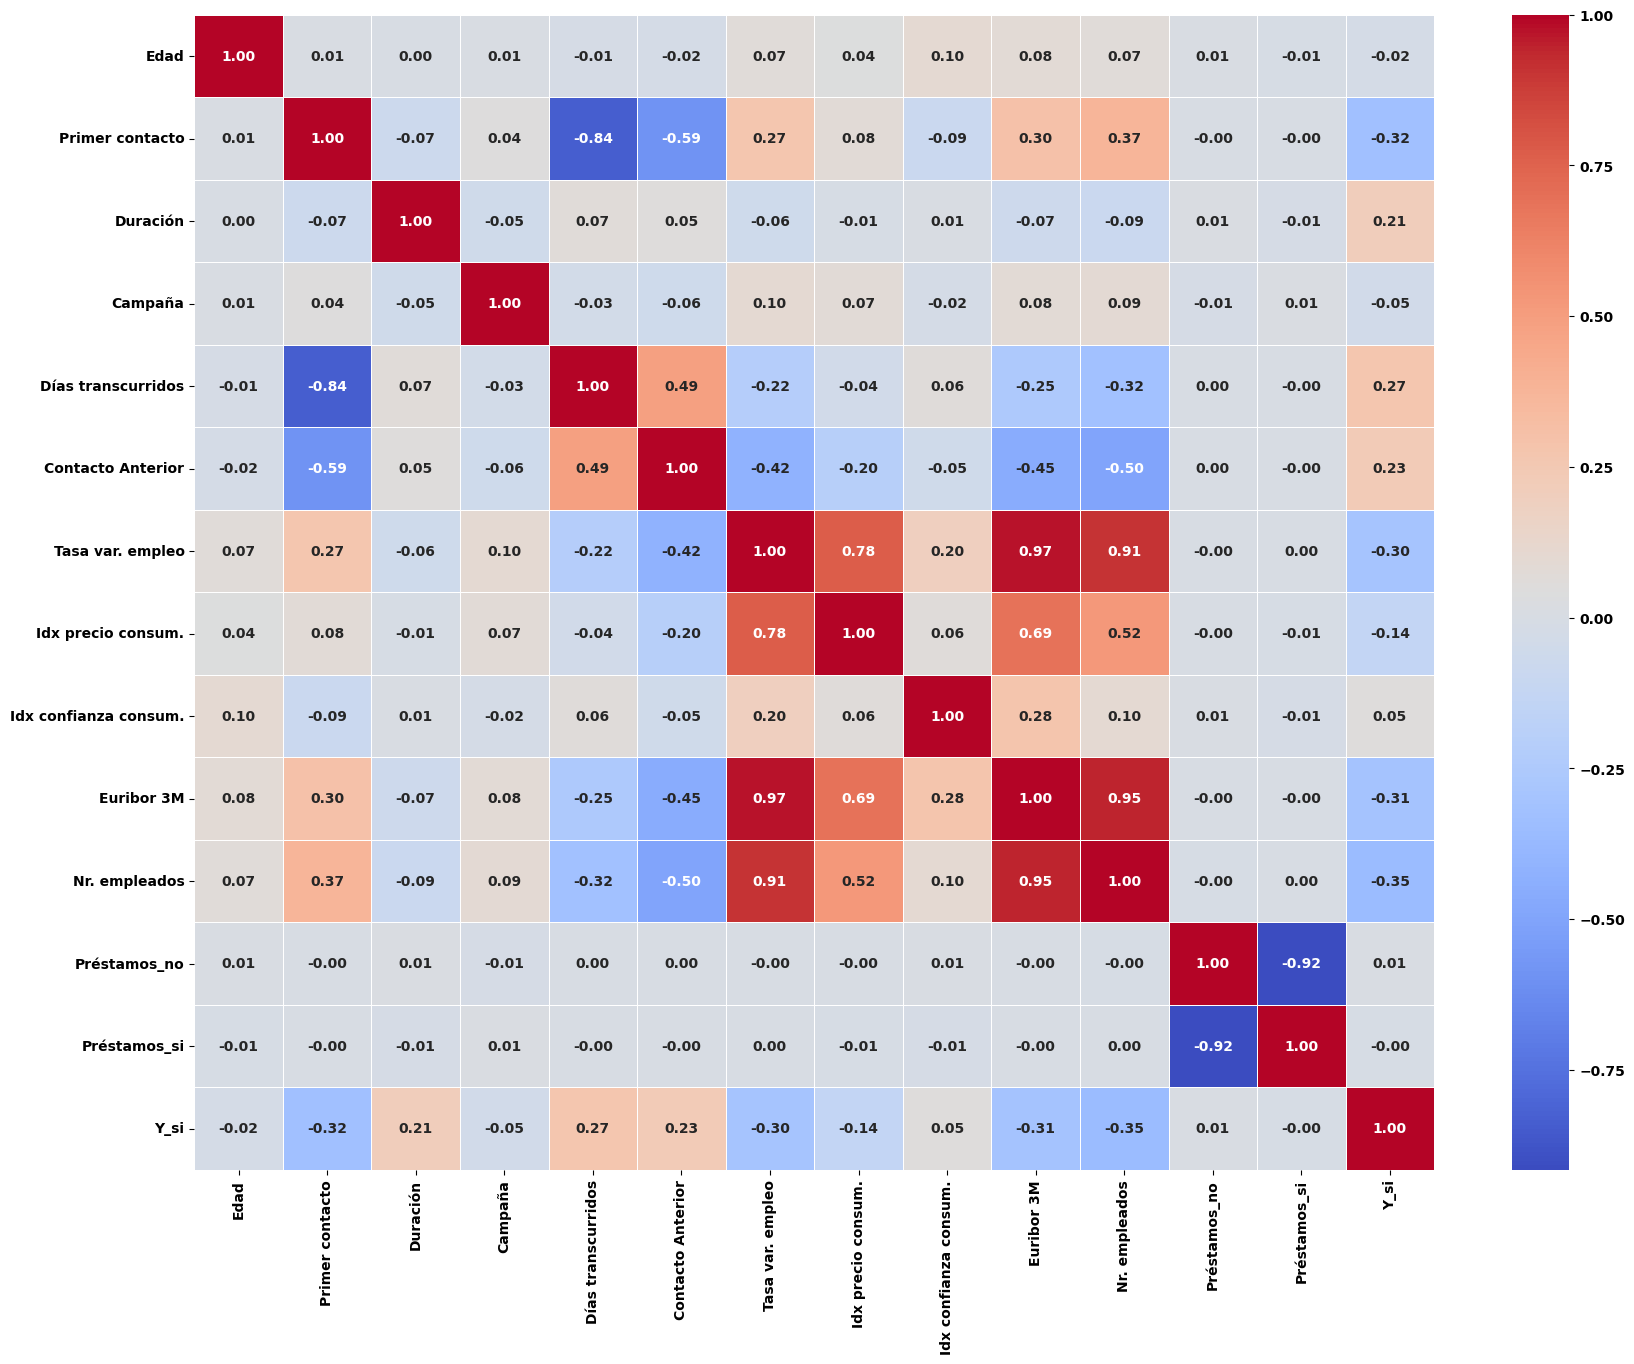

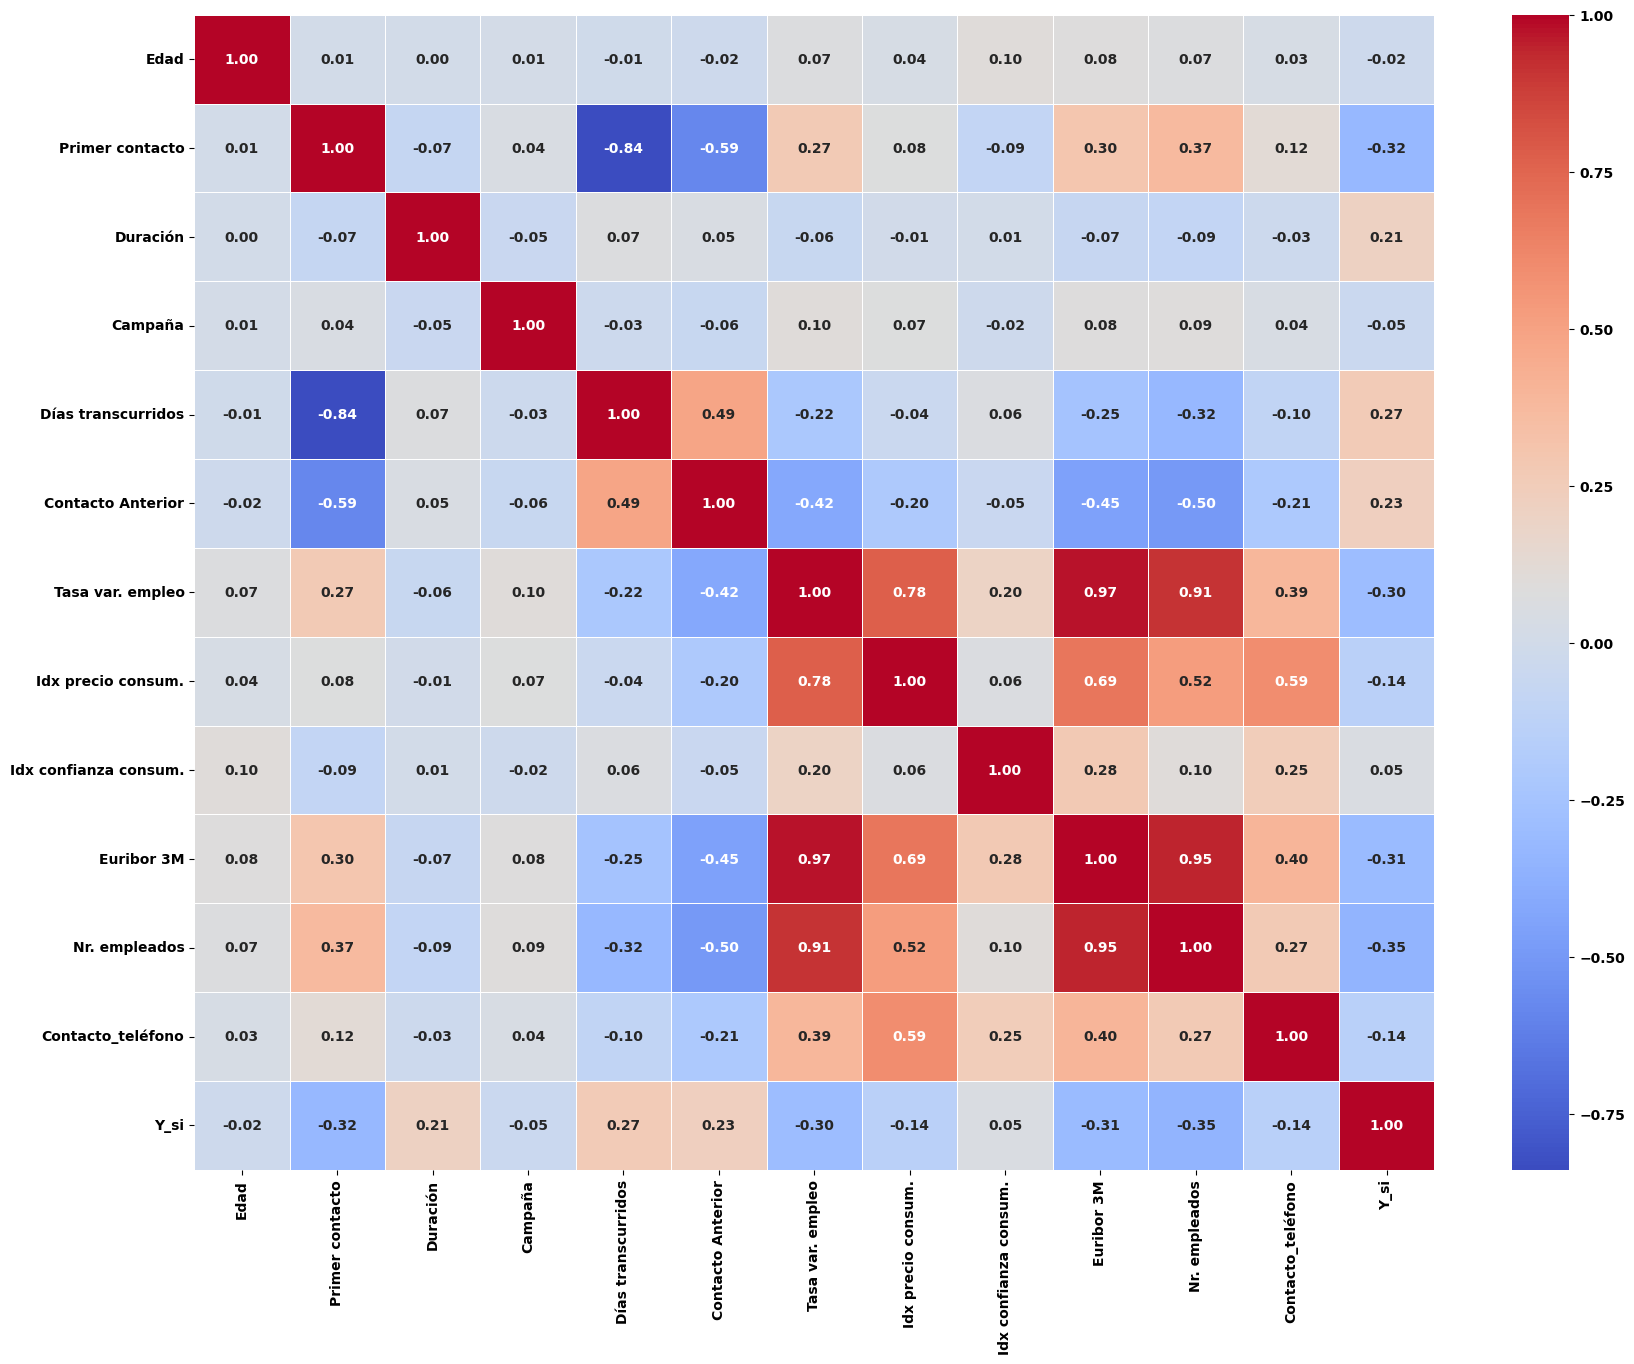

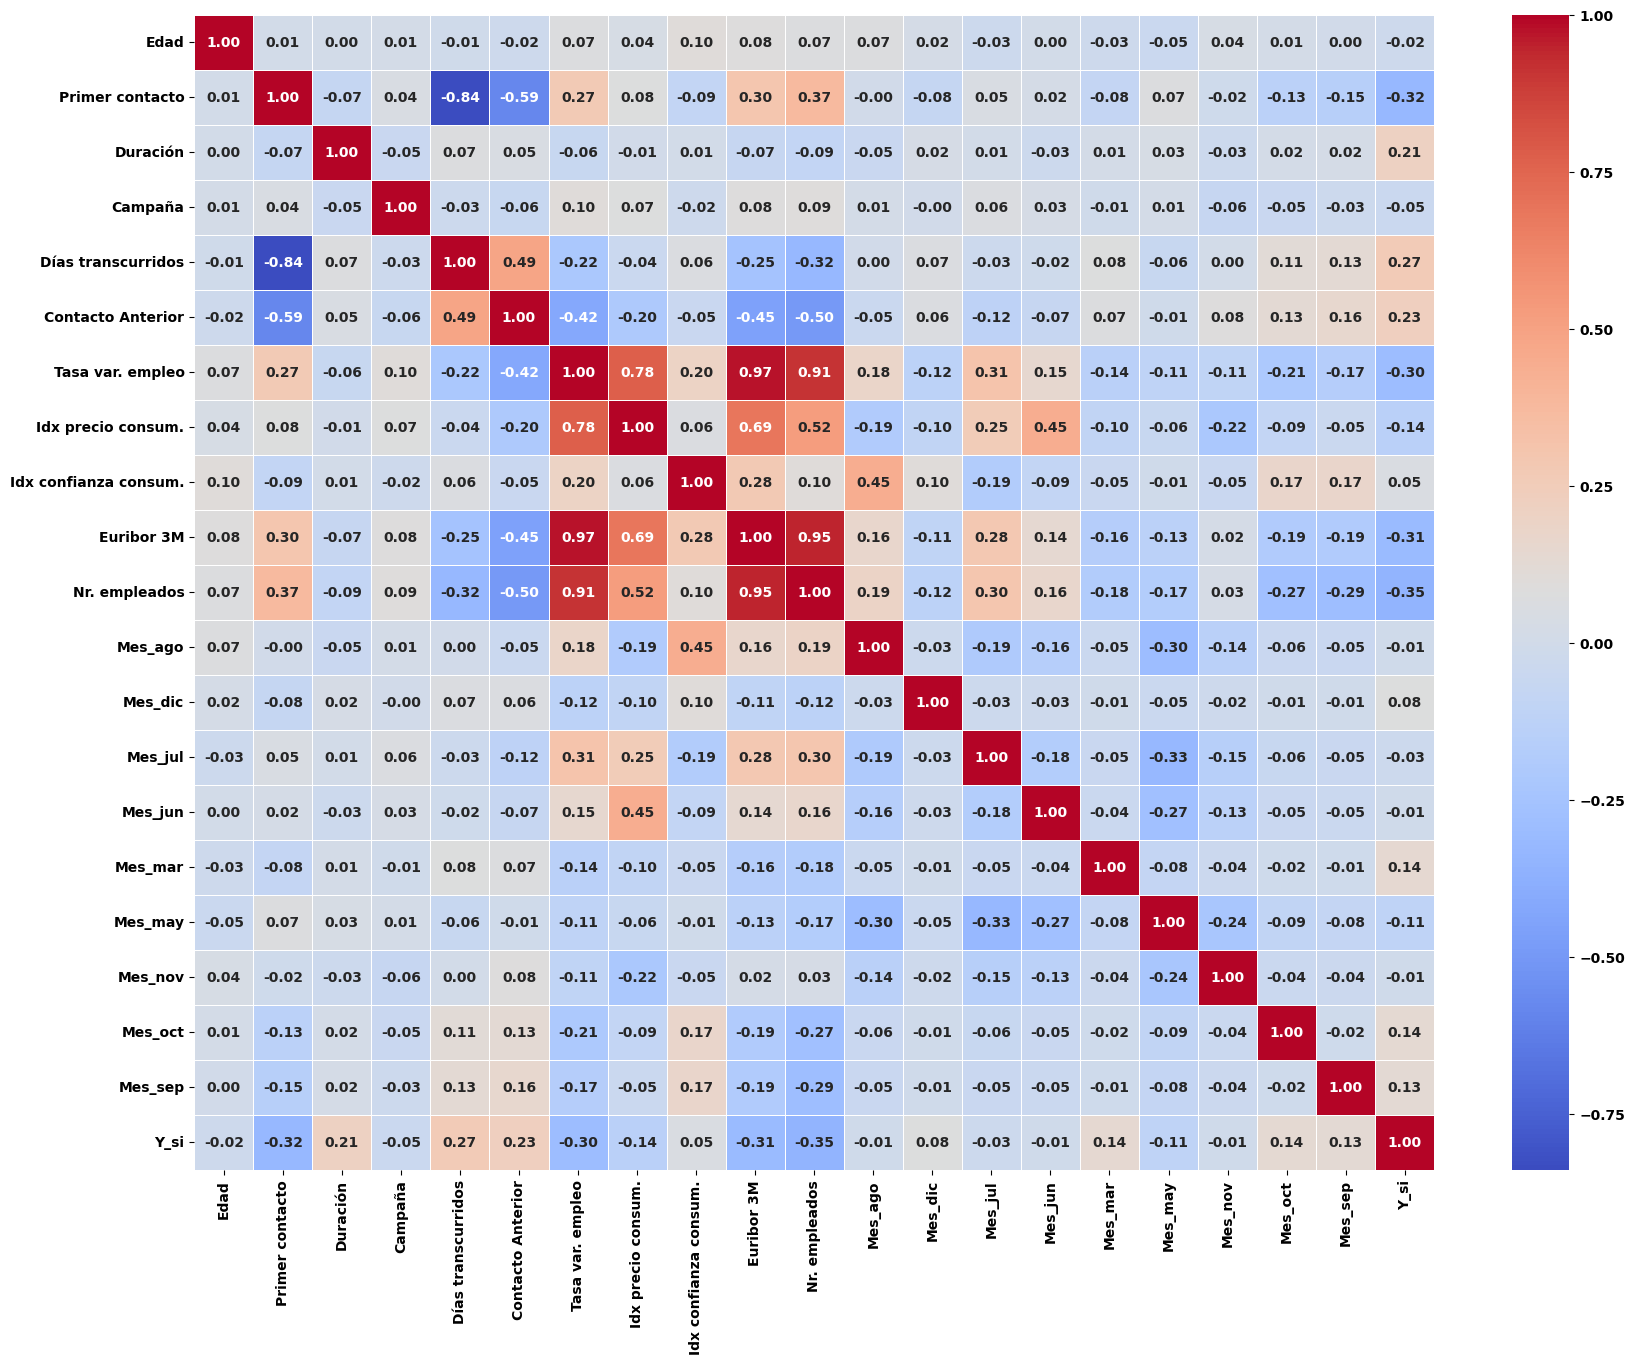

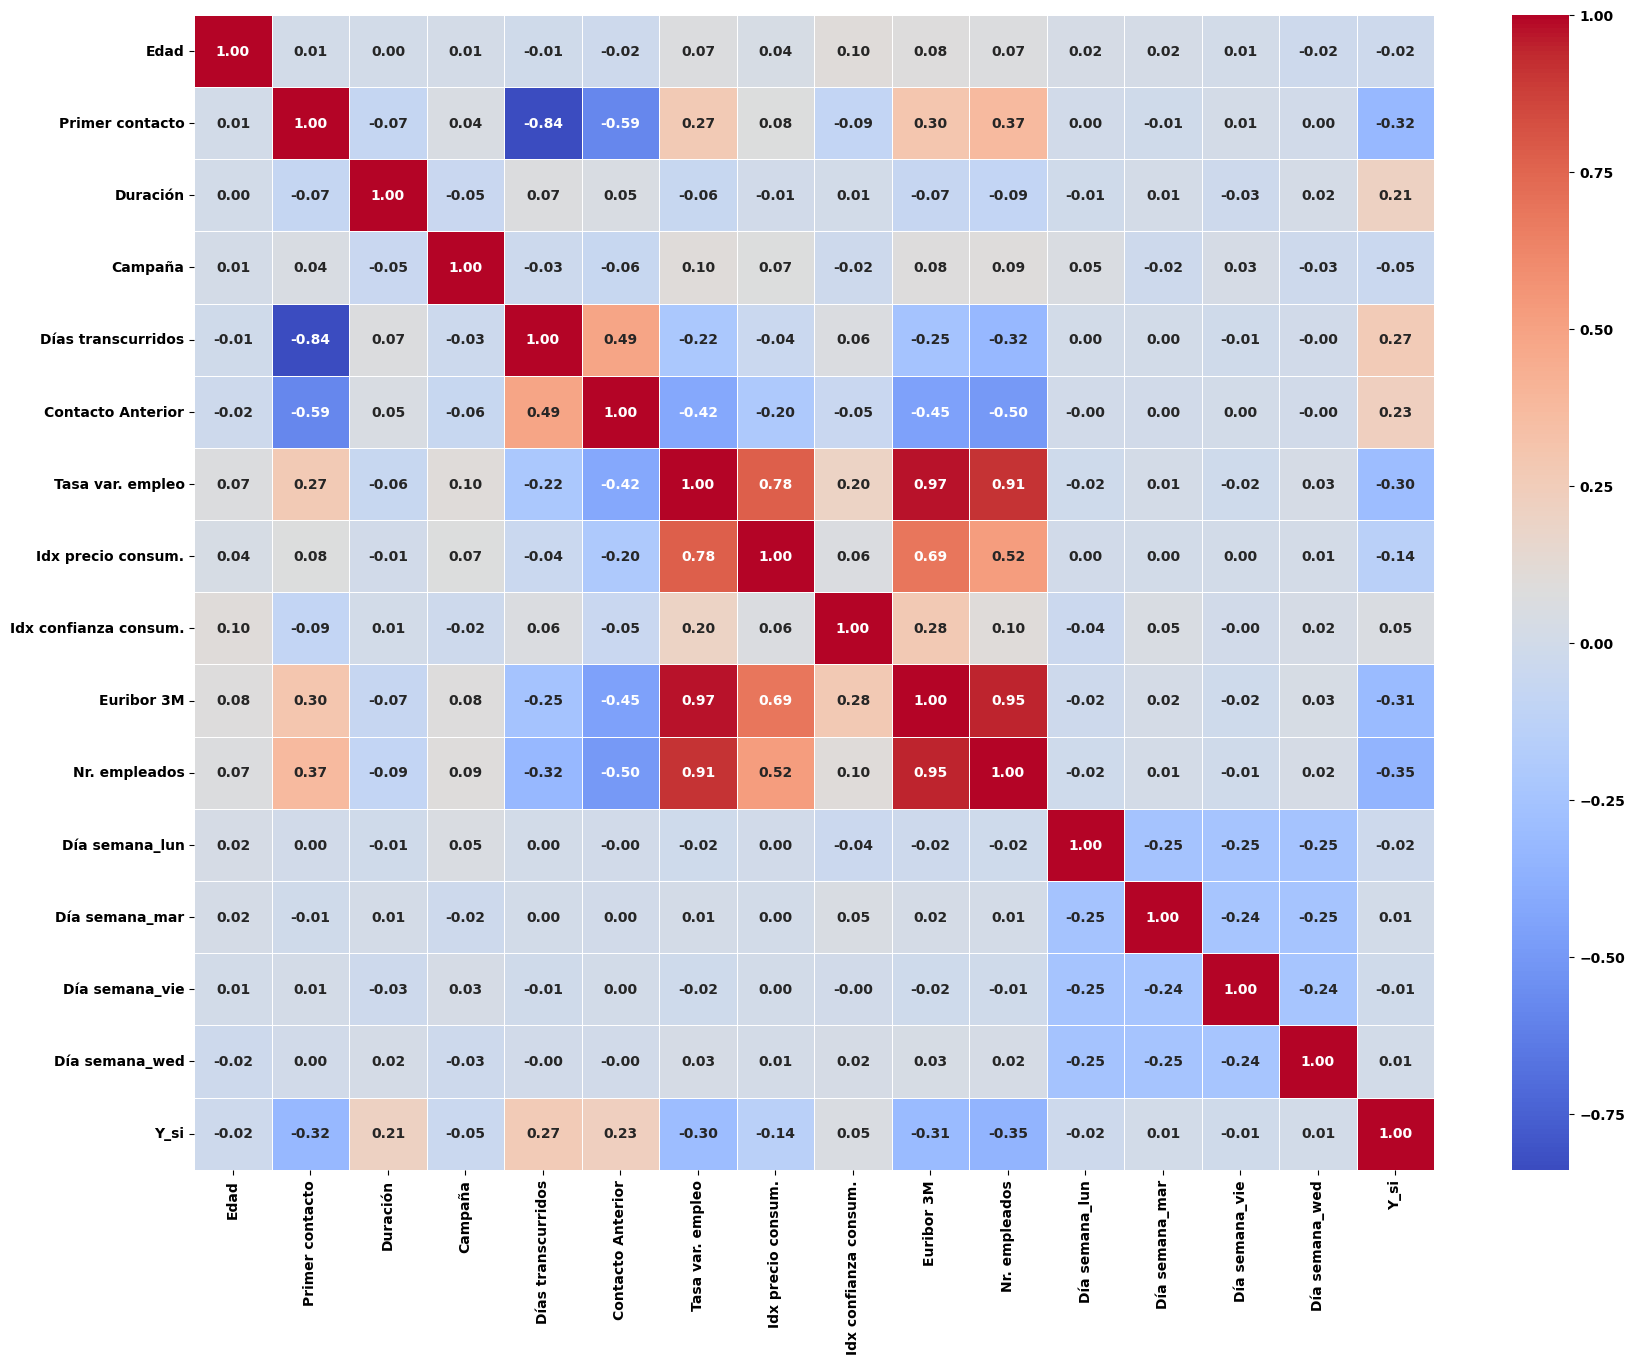

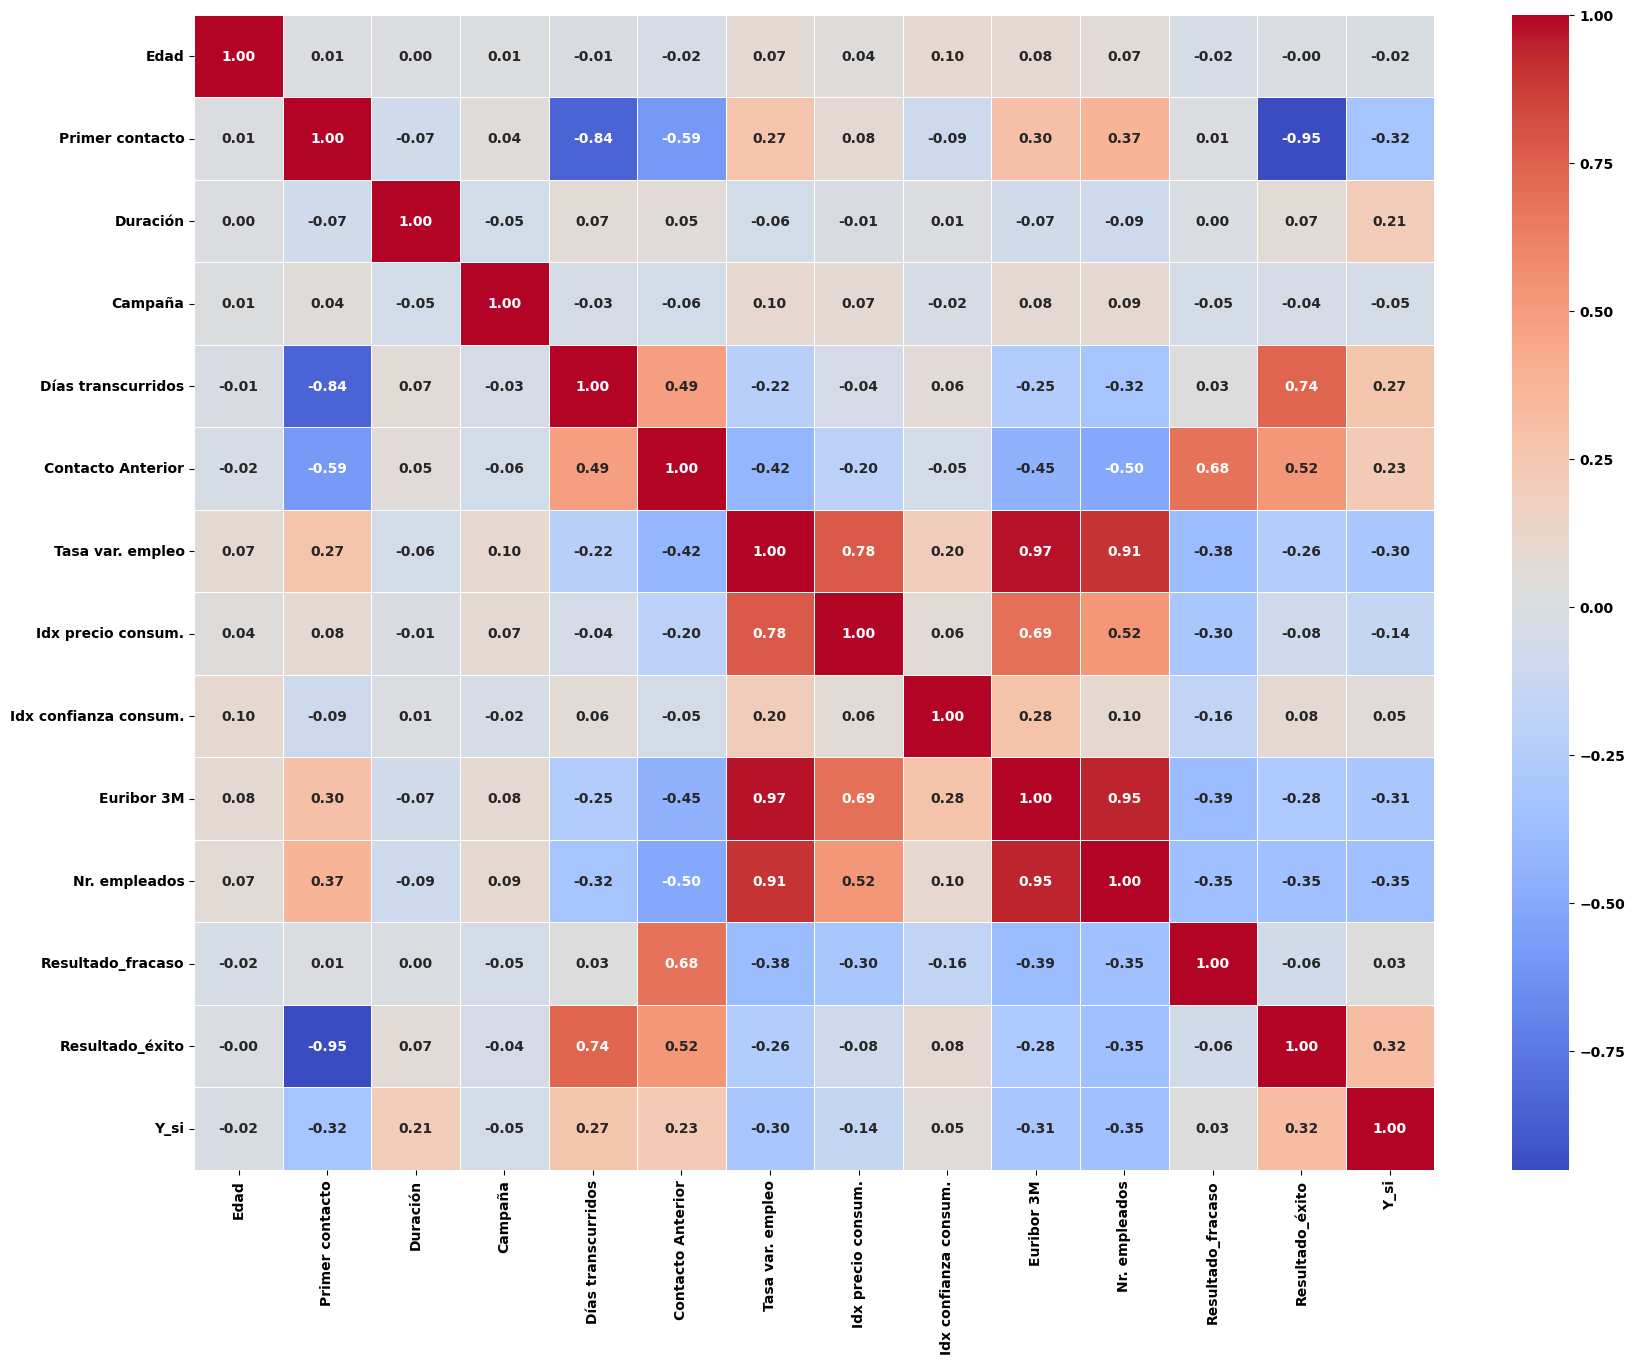

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_columns = df.select_dtypes(['object']).columns
cat_columns = cat_columns.drop('Y')

for col in cat_columns:
    categorical_columns = [col, Col.Y]
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

    selected_columns = categorical_columns + list(numeric_columns)

    data_subset = df[selected_columns]
    data_encoded = pd.get_dummies(data_subset, columns=categorical_columns, drop_first=True)
    correlation_matrix = data_encoded.corr()


    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 15))

    # Dibujar el mapa de calor de la matriz de correlación
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

    # Mostrar el gráfico
    plt.show()

De todos los graficos listados, lo que se pretendió hacer es buscar una relación entre las columnas categóricas vs las columnas numéricas y principalmente contra la columna target.
De todas las columnas categóricas, solo la columna "Resultado" que representa el resultado de una campaña anterior tiene una moderada relación lineal con "Dias transcurridos" para el caso de el resultado de éxito. Para el caso de resultado "fracaso", la relación se presenta con la columna "Contacto anterior" la cual representa el número de contactos anterior a dicho cliente.
En el caso de Resultado de éxito, existe una relación con la suscripción al producto pero no termina siendo lo suficiente fuerte como para relacionarla con la respuesta del cliente.